# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.466779698324851 -2.606996774785296
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [167]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [168]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [169]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [191]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [192]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [193]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [194]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [195]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    #Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.reshape(rewards[-1], [1])])
    Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [196]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [197]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [198]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [199]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [200]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [201]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [202]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:8.0000 rate:0.0160 gloss:-0.0364 dloss:1.3534 dlossR:0.6606 dlossQ:0.6928
Episode:1 meanR:9.0000 rate:0.0200 gloss:0.0566 dloss:1.4271 dlossR:0.7352 dlossQ:0.6919
Episode:2 meanR:9.3333 rate:0.0200 gloss:0.0267 dloss:1.4024 dlossR:0.7096 dlossQ:0.6928
Episode:3 meanR:9.2500 rate:0.0180 gloss:-0.0003 dloss:1.3775 dlossR:0.6843 dlossQ:0.6932
Episode:4 meanR:9.2000 rate:0.0180 gloss:-0.0215 dloss:1.3550 dlossR:0.6620 dlossQ:0.6930
Episode:5 meanR:9.3333 rate:0.0200 gloss:-0.0460 dloss:1.3256 dlossR:0.6336 dlossQ:0.6920
Episode:6 meanR:9.2857 rate:0.0180 gloss:-0.0654 dloss:1.3072 dlossR:0.6163 dlossQ:0.6910
Episode:7 meanR:9.2500 rate:0.0180 gloss:-0.0900 dloss:1.2820 dlossR:0.5929 dlossQ:0.6890
Episode:8 meanR:9.2222 rate:0.0180 gloss:-0.1177 dloss:1.2588 dlossR:0.5722 dlossQ:0.6867
Episode:9 meanR:9.2000 rate:0.0180 gloss:-0.1471 dloss:1.2367 dlossR:0.5527 dlossQ:0.6839
Episode:10 meanR:9.0909 rate:0.0160 gloss:-0.1718 dloss:1.2271 dlossR:0.5440 dlossQ:0.6831
Episode:11 

Episode:90 meanR:52.9670 rate:0.1580 gloss:-0.8710 dloss:0.9747 dlossR:0.4456 dlossQ:0.5292
Episode:91 meanR:53.2609 rate:0.1600 gloss:-0.8679 dloss:0.9789 dlossR:0.4491 dlossQ:0.5298
Episode:92 meanR:53.1828 rate:0.0920 gloss:-1.1303 dloss:0.7741 dlossR:0.3244 dlossQ:0.4497
Episode:93 meanR:53.1702 rate:0.1040 gloss:-1.0706 dloss:0.8158 dlossR:0.3469 dlossQ:0.4689
Episode:94 meanR:52.8105 rate:0.0380 gloss:-0.9803 dloss:0.7554 dlossR:0.2534 dlossQ:0.5020
Episode:95 meanR:52.4167 rate:0.0300 gloss:-1.0468 dloss:0.7158 dlossR:0.2264 dlossQ:0.4895
Episode:96 meanR:52.0103 rate:0.0260 gloss:-1.0427 dloss:0.7111 dlossR:0.2199 dlossQ:0.4911
Episode:97 meanR:51.6122 rate:0.0260 gloss:-1.0375 dloss:0.7138 dlossR:0.2211 dlossQ:0.4927
Episode:98 meanR:51.2424 rate:0.0300 gloss:-1.1226 dloss:0.6882 dlossR:0.2155 dlossQ:0.4727
Episode:99 meanR:50.8300 rate:0.0200 gloss:-1.1158 dloss:0.6761 dlossR:0.1952 dlossQ:0.4808
Episode:100 meanR:50.8600 rate:0.0220 gloss:-1.1431 dloss:0.6737 dlossR:0.1959 d

Episode:182 meanR:52.1600 rate:0.3280 gloss:-0.9618 dloss:1.2491 dlossR:0.7347 dlossQ:0.5143
Episode:183 meanR:52.4600 rate:0.1540 gloss:-1.0186 dloss:0.9292 dlossR:0.4338 dlossQ:0.4954
Episode:184 meanR:52.1000 rate:0.0180 gloss:-1.7255 dloss:0.5685 dlossR:0.1303 dlossQ:0.4382
Episode:185 meanR:52.5300 rate:0.1280 gloss:-1.0320 dloss:0.8752 dlossR:0.3882 dlossQ:0.4869
Episode:186 meanR:52.8700 rate:0.2040 gloss:-0.9919 dloss:1.0113 dlossR:0.5142 dlossQ:0.4972
Episode:187 meanR:52.9600 rate:0.2740 gloss:-0.9281 dloss:1.1475 dlossR:0.6279 dlossQ:0.5195
Episode:188 meanR:53.6400 rate:0.3320 gloss:-1.0333 dloss:1.2541 dlossR:0.7625 dlossQ:0.4915
Episode:189 meanR:54.3200 rate:0.3020 gloss:-0.8113 dloss:1.2132 dlossR:0.6571 dlossQ:0.5561
Episode:190 meanR:55.0700 rate:0.3080 gloss:-0.7889 dloss:1.2261 dlossR:0.6621 dlossQ:0.5640
Episode:191 meanR:55.5700 rate:0.2600 gloss:-1.0323 dloss:1.1074 dlossR:0.6198 dlossQ:0.4875
Episode:192 meanR:56.7700 rate:0.3320 gloss:-0.7634 dloss:1.2682 dloss

Episode:271 meanR:104.1000 rate:0.0220 gloss:-0.8148 dloss:0.8278 dlossR:0.2691 dlossQ:0.5587
Episode:272 meanR:104.0700 rate:0.0260 gloss:-0.9241 dloss:0.7690 dlossR:0.2474 dlossQ:0.5216
Episode:273 meanR:104.0100 rate:0.0220 gloss:-1.0201 dloss:0.7176 dlossR:0.2186 dlossQ:0.4989
Episode:274 meanR:104.0000 rate:0.0180 gloss:-1.0343 dloss:0.7110 dlossR:0.2073 dlossQ:0.5037
Episode:275 meanR:104.4100 rate:0.1080 gloss:-1.0480 dloss:0.8406 dlossR:0.3569 dlossQ:0.4837
Episode:276 meanR:104.4000 rate:0.0180 gloss:-1.9362 dloss:0.5881 dlossR:0.1324 dlossQ:0.4557
Episode:277 meanR:106.8900 rate:0.5200 gloss:-0.5353 dloss:1.5790 dlossR:0.9284 dlossQ:0.6507
Episode:278 meanR:111.7800 rate:1.0000 gloss:0.0095 dloss:2.1291 dlossR:1.3141 dlossQ:0.8150
Episode:279 meanR:113.3000 rate:0.3300 gloss:-0.7228 dloss:1.2713 dlossR:0.6838 dlossQ:0.5875
Episode:280 meanR:113.4700 rate:0.0720 gloss:-0.9770 dloss:0.8128 dlossR:0.3086 dlossQ:0.5041
Episode:281 meanR:113.6400 rate:0.0820 gloss:-0.9353 dloss:0.

Episode:363 meanR:78.5300 rate:0.0520 gloss:-1.2654 dloss:0.6704 dlossR:0.2374 dlossQ:0.4329
Episode:364 meanR:78.5000 rate:0.0720 gloss:-1.4311 dloss:0.6469 dlossR:0.2667 dlossQ:0.3802
Episode:365 meanR:78.5900 rate:0.0720 gloss:-1.2877 dloss:0.6872 dlossR:0.2744 dlossQ:0.4128
Episode:366 meanR:78.8900 rate:0.1180 gloss:-1.0306 dloss:0.8800 dlossR:0.3882 dlossQ:0.4918
Episode:367 meanR:80.1300 rate:0.2900 gloss:-0.8555 dloss:1.2116 dlossR:0.6771 dlossQ:0.5345
Episode:368 meanR:80.9500 rate:0.2020 gloss:-1.3158 dloss:0.9779 dlossR:0.5608 dlossQ:0.4171
Episode:369 meanR:81.7300 rate:0.1960 gloss:-1.2494 dloss:0.9755 dlossR:0.5409 dlossQ:0.4345
Episode:370 meanR:81.6800 rate:0.0200 gloss:-1.9227 dloss:0.4987 dlossR:0.1243 dlossQ:0.3744
Episode:371 meanR:81.7900 rate:0.0440 gloss:-1.8606 dloss:0.5250 dlossR:0.1957 dlossQ:0.3293
Episode:372 meanR:81.9100 rate:0.0500 gloss:-1.5137 dloss:0.5751 dlossR:0.2150 dlossQ:0.3601
Episode:373 meanR:83.2100 rate:0.2820 gloss:-1.1780 dloss:1.1506 dloss

Episode:453 meanR:114.3400 rate:0.2300 gloss:-0.5979 dloss:1.1602 dlossR:0.5483 dlossQ:0.6119
Episode:454 meanR:114.9600 rate:0.1780 gloss:-0.5730 dloss:1.1123 dlossR:0.4939 dlossQ:0.6184
Episode:455 meanR:115.8300 rate:0.2360 gloss:-0.4348 dloss:1.2112 dlossR:0.5603 dlossQ:0.6508
Episode:456 meanR:115.8600 rate:0.1380 gloss:-0.5821 dloss:1.0708 dlossR:0.4548 dlossQ:0.6160
Episode:457 meanR:115.7200 rate:0.1380 gloss:-0.5819 dloss:1.0716 dlossR:0.4561 dlossQ:0.6154
Episode:458 meanR:115.2300 rate:0.1640 gloss:-0.4830 dloss:1.1346 dlossR:0.4960 dlossQ:0.6386
Episode:459 meanR:115.9700 rate:0.3060 gloss:-0.6411 dloss:1.2472 dlossR:0.6437 dlossQ:0.6036
Episode:460 meanR:116.4200 rate:0.1800 gloss:-0.5391 dloss:1.1282 dlossR:0.5024 dlossQ:0.6258
Episode:461 meanR:116.7300 rate:0.1400 gloss:-0.5398 dloss:1.0914 dlossR:0.4656 dlossQ:0.6258
Episode:462 meanR:117.2400 rate:0.1720 gloss:-0.5902 dloss:1.1025 dlossR:0.4889 dlossQ:0.6137
Episode:463 meanR:117.9200 rate:0.1880 gloss:-0.5857 dloss:1

Episode:546 meanR:61.2500 rate:0.0280 gloss:-1.4039 dloss:0.5689 dlossR:0.1696 dlossQ:0.3993
Episode:547 meanR:60.6500 rate:0.1280 gloss:-1.2473 dloss:0.8047 dlossR:0.3856 dlossQ:0.4191
Episode:548 meanR:60.2200 rate:0.1200 gloss:-1.6777 dloss:0.7003 dlossR:0.3906 dlossQ:0.3097
Episode:549 meanR:59.9300 rate:0.1100 gloss:-1.2275 dloss:0.7777 dlossR:0.3500 dlossQ:0.4276
Episode:550 meanR:59.0200 rate:0.0980 gloss:-1.2271 dloss:0.7604 dlossR:0.3303 dlossQ:0.4301
Episode:551 meanR:55.4300 rate:0.0220 gloss:-1.7528 dloss:0.5255 dlossR:0.1357 dlossQ:0.3898
Episode:552 meanR:54.7200 rate:0.1100 gloss:-1.1545 dloss:0.8015 dlossR:0.3530 dlossQ:0.4484
Episode:553 meanR:54.0800 rate:0.1020 gloss:-1.3454 dloss:0.7238 dlossR:0.3327 dlossQ:0.3910
Episode:554 meanR:54.2500 rate:0.2120 gloss:-1.2687 dloss:0.9797 dlossR:0.5654 dlossQ:0.4143
Episode:555 meanR:53.4800 rate:0.0820 gloss:-1.3652 dloss:0.7017 dlossR:0.2970 dlossQ:0.4046
Episode:556 meanR:53.1500 rate:0.0720 gloss:-1.3942 dloss:0.6739 dloss

Episode:636 meanR:56.1100 rate:0.0340 gloss:-0.9039 dloss:0.7855 dlossR:0.2618 dlossQ:0.5237
Episode:637 meanR:56.1100 rate:0.0440 gloss:-0.8429 dloss:0.8346 dlossR:0.2931 dlossQ:0.5415
Episode:638 meanR:56.0700 rate:0.0220 gloss:-0.9799 dloss:0.7258 dlossR:0.2201 dlossQ:0.5058
Episode:639 meanR:56.0100 rate:0.0220 gloss:-1.0020 dloss:0.7193 dlossR:0.2155 dlossQ:0.5039
Episode:640 meanR:55.9500 rate:0.0200 gloss:-1.1467 dloss:0.6682 dlossR:0.1854 dlossQ:0.4828
Episode:641 meanR:56.0800 rate:0.0500 gloss:-0.9202 dloss:0.8045 dlossR:0.2837 dlossQ:0.5207
Episode:642 meanR:56.3600 rate:0.0840 gloss:-0.9546 dloss:0.8353 dlossR:0.3272 dlossQ:0.5082
Episode:643 meanR:57.0000 rate:0.1500 gloss:-1.0632 dloss:0.8977 dlossR:0.4243 dlossQ:0.4734
Episode:644 meanR:57.2600 rate:0.0720 gloss:-1.5282 dloss:0.6571 dlossR:0.2784 dlossQ:0.3787
Episode:645 meanR:57.2700 rate:0.0240 gloss:-1.9973 dloss:0.4708 dlossR:0.1322 dlossQ:0.3386
Episode:646 meanR:57.6100 rate:0.0960 gloss:-1.3142 dloss:0.7612 dloss

Episode:725 meanR:51.0200 rate:0.1540 gloss:-0.9879 dloss:0.9353 dlossR:0.4369 dlossQ:0.4984
Episode:726 meanR:51.9100 rate:0.2180 gloss:-0.8000 dloss:1.0903 dlossR:0.5351 dlossQ:0.5552
Episode:727 meanR:53.3300 rate:0.3300 gloss:-0.5579 dloss:1.2908 dlossR:0.6690 dlossQ:0.6218
Episode:728 meanR:55.9800 rate:0.5880 gloss:-0.4651 dloss:1.6742 dlossR:1.0053 dlossQ:0.6689
Episode:729 meanR:55.6900 rate:0.0220 gloss:-1.3937 dloss:0.5934 dlossR:0.1615 dlossQ:0.4319
Episode:730 meanR:55.6600 rate:0.1520 gloss:-1.0469 dloss:0.9100 dlossR:0.4279 dlossQ:0.4822
Episode:731 meanR:55.0300 rate:0.3200 gloss:-0.6319 dloss:1.2670 dlossR:0.6650 dlossQ:0.6020
Episode:732 meanR:55.2700 rate:0.2260 gloss:-0.6873 dloss:1.1340 dlossR:0.5541 dlossQ:0.5799
Episode:733 meanR:55.0600 rate:0.0660 gloss:-1.1027 dloss:0.7413 dlossR:0.2787 dlossQ:0.4626
Episode:734 meanR:54.8800 rate:0.0420 gloss:-1.0730 dloss:0.7182 dlossR:0.2433 dlossQ:0.4749
Episode:735 meanR:54.7400 rate:0.0360 gloss:-1.1264 dloss:0.6904 dloss

Episode:814 meanR:66.1000 rate:0.3120 gloss:-0.4093 dloss:1.2902 dlossR:0.6453 dlossQ:0.6449
Episode:815 meanR:67.2800 rate:0.4460 gloss:-0.2212 dloss:1.4307 dlossR:0.7516 dlossQ:0.6791
Episode:816 meanR:69.3300 rate:0.5660 gloss:-0.0866 dloss:1.5294 dlossR:0.8211 dlossQ:0.7082
Episode:817 meanR:70.2900 rate:0.2920 gloss:-0.7315 dloss:1.2091 dlossR:0.6280 dlossQ:0.5811
Episode:818 meanR:70.6200 rate:0.1480 gloss:-0.7957 dloss:0.9913 dlossR:0.4336 dlossQ:0.5577
Episode:819 meanR:70.5300 rate:0.0220 gloss:-1.0387 dloss:0.7184 dlossR:0.2149 dlossQ:0.5035
Episode:820 meanR:70.9500 rate:0.1160 gloss:-0.8452 dloss:0.9290 dlossR:0.3865 dlossQ:0.5425
Episode:821 meanR:71.5500 rate:0.1500 gloss:-0.8274 dloss:0.9800 dlossR:0.4329 dlossQ:0.5471
Episode:822 meanR:72.2600 rate:0.1740 gloss:-0.8399 dloss:1.0082 dlossR:0.4647 dlossQ:0.5435
Episode:823 meanR:75.6400 rate:0.6940 gloss:0.0869 dloss:1.5965 dlossR:0.8625 dlossQ:0.7340
Episode:824 meanR:78.4900 rate:0.6020 gloss:0.0300 dloss:1.5284 dlossR:

Episode:902 meanR:145.6000 rate:0.5700 gloss:-0.3286 dloss:1.6049 dlossR:0.9026 dlossQ:0.7024
Episode:903 meanR:148.0700 rate:0.5760 gloss:-0.2912 dloss:1.6027 dlossR:0.8928 dlossQ:0.7099
Episode:904 meanR:149.1800 rate:0.4160 gloss:-0.3679 dloss:1.4035 dlossR:0.7247 dlossQ:0.6788
Episode:905 meanR:151.2000 rate:1.0000 gloss:0.5897 dloss:1.4975 dlossR:0.7732 dlossQ:0.7243
Episode:906 meanR:152.2200 rate:0.6500 gloss:-0.0842 dloss:1.6280 dlossR:0.8863 dlossQ:0.7417
Episode:907 meanR:152.2300 rate:0.4040 gloss:0.3087 dloss:1.3875 dlossR:0.7037 dlossQ:0.6838
Episode:908 meanR:154.6800 rate:0.8780 gloss:0.1783 dloss:1.7592 dlossR:0.9806 dlossQ:0.7786
Episode:909 meanR:158.1200 rate:1.0000 gloss:0.6574 dloss:1.4232 dlossR:0.7192 dlossQ:0.7040
Episode:910 meanR:159.6600 rate:0.5900 gloss:0.0348 dloss:1.5159 dlossR:0.7812 dlossQ:0.7347
Episode:911 meanR:163.5700 rate:1.0000 gloss:0.6925 dloss:1.3854 dlossR:0.6928 dlossQ:0.6926
Episode:912 meanR:166.9900 rate:0.7040 gloss:0.2008 dloss:1.5448 d

Episode:990 meanR:178.8700 rate:0.3380 gloss:-0.0257 dloss:1.3575 dlossR:0.6536 dlossQ:0.7039
Episode:991 meanR:179.4900 rate:0.3520 gloss:-0.2068 dloss:1.3470 dlossR:0.6520 dlossQ:0.6950
Episode:992 meanR:179.4000 rate:0.2000 gloss:-0.0695 dloss:1.3103 dlossR:0.6177 dlossQ:0.6926
Episode:993 meanR:183.1500 rate:1.0000 gloss:0.2980 dloss:1.8146 dlossR:1.0203 dlossQ:0.7943
Episode:994 meanR:182.4600 rate:0.1660 gloss:-0.0494 dloss:1.3158 dlossR:0.6235 dlossQ:0.6923
Episode:995 meanR:180.3500 rate:0.2080 gloss:-0.0346 dloss:1.3239 dlossR:0.6289 dlossQ:0.6950
Episode:996 meanR:179.4100 rate:0.2160 gloss:-0.0499 dloss:1.3193 dlossR:0.6240 dlossQ:0.6954
Episode:997 meanR:180.0500 rate:0.9340 gloss:0.5225 dloss:1.5001 dlossR:0.7756 dlossQ:0.7244
Episode:998 meanR:178.5300 rate:0.2120 gloss:-0.0453 dloss:1.3204 dlossR:0.6233 dlossQ:0.6972
Episode:999 meanR:180.4300 rate:1.0000 gloss:0.3552 dloss:1.7509 dlossR:0.9664 dlossQ:0.7845
Episode:1000 meanR:177.6000 rate:0.1940 gloss:-0.0605 dloss:1.3

Episode:1079 meanR:106.0600 rate:0.1720 gloss:-0.8883 dloss:0.9924 dlossR:0.4626 dlossQ:0.5298
Episode:1080 meanR:104.5900 rate:0.1240 gloss:-1.1246 dloss:0.8357 dlossR:0.3799 dlossQ:0.4558
Episode:1081 meanR:99.9200 rate:0.0660 gloss:-1.1498 dloss:0.7464 dlossR:0.2827 dlossQ:0.4637
Episode:1082 meanR:98.8000 rate:0.1740 gloss:-0.9606 dloss:0.9801 dlossR:0.4680 dlossQ:0.5121
Episode:1083 meanR:97.0200 rate:0.1140 gloss:-1.0890 dloss:0.8295 dlossR:0.3635 dlossQ:0.4659
Episode:1084 meanR:96.3000 rate:0.0480 gloss:-1.0625 dloss:0.7384 dlossR:0.2568 dlossQ:0.4816
Episode:1085 meanR:94.7800 rate:0.0240 gloss:-1.3929 dloss:0.6049 dlossR:0.1719 dlossQ:0.4330
Episode:1086 meanR:89.8900 rate:0.0220 gloss:-1.1163 dloss:0.6815 dlossR:0.1998 dlossQ:0.4817
Episode:1087 meanR:87.9100 rate:0.0280 gloss:-1.1237 dloss:0.6765 dlossR:0.2102 dlossQ:0.4663
Episode:1088 meanR:87.2200 rate:0.0300 gloss:-1.1056 dloss:0.6926 dlossR:0.2179 dlossQ:0.4746
Episode:1089 meanR:85.6500 rate:0.0260 gloss:-1.1433 dloss

Episode:1167 meanR:138.5500 rate:1.0000 gloss:0.4806 dloss:1.6162 dlossR:0.8599 dlossQ:0.7563
Episode:1168 meanR:143.4500 rate:1.0000 gloss:0.5400 dloss:1.5508 dlossR:0.8113 dlossQ:0.7396
Episode:1169 meanR:143.4500 rate:1.0000 gloss:0.5286 dloss:1.5636 dlossR:0.8221 dlossQ:0.7415
Episode:1170 meanR:147.6400 rate:1.0000 gloss:0.5833 dloss:1.5036 dlossR:0.7765 dlossQ:0.7271
Episode:1171 meanR:152.1500 rate:1.0000 gloss:0.5972 dloss:1.4886 dlossR:0.7658 dlossQ:0.7228
Episode:1172 meanR:156.7400 rate:1.0000 gloss:0.6147 dloss:1.4695 dlossR:0.7520 dlossQ:0.7175
Episode:1173 meanR:161.4800 rate:1.0000 gloss:0.6317 dloss:1.4511 dlossR:0.7390 dlossQ:0.7121
Episode:1174 meanR:166.1900 rate:1.0000 gloss:0.6490 dloss:1.4325 dlossR:0.7262 dlossQ:0.7063
Episode:1175 meanR:170.9400 rate:1.0000 gloss:0.6838 dloss:1.3955 dlossR:0.7011 dlossQ:0.6944
Episode:1176 meanR:174.0600 rate:0.7000 gloss:0.4796 dloss:1.3895 dlossR:0.7014 dlossQ:0.6880
Episode:1177 meanR:175.5200 rate:0.3760 gloss:0.3199 dloss:1

Episode:1255 meanR:155.0300 rate:0.5380 gloss:0.0996 dloss:1.4552 dlossR:0.7371 dlossQ:0.7181
Episode:1256 meanR:156.4000 rate:0.3760 gloss:0.0517 dloss:1.3777 dlossR:0.6750 dlossQ:0.7028
Episode:1257 meanR:156.0300 rate:0.2660 gloss:0.0285 dloss:1.3486 dlossR:0.6501 dlossQ:0.6985
Episode:1258 meanR:155.8800 rate:0.2300 gloss:-0.0216 dloss:1.3304 dlossR:0.6351 dlossQ:0.6953
Episode:1259 meanR:156.0000 rate:0.2300 gloss:-0.0453 dloss:1.3231 dlossR:0.6292 dlossQ:0.6939
Episode:1260 meanR:152.2400 rate:0.2480 gloss:-0.1169 dloss:1.3067 dlossR:0.6188 dlossQ:0.6880
Episode:1261 meanR:148.1000 rate:0.1720 gloss:-0.0976 dloss:1.2957 dlossR:0.6063 dlossQ:0.6894
Episode:1262 meanR:143.8700 rate:0.1540 gloss:-0.1219 dloss:1.2831 dlossR:0.5960 dlossQ:0.6872
Episode:1263 meanR:139.5900 rate:0.1440 gloss:-0.1415 dloss:1.2729 dlossR:0.5870 dlossQ:0.6859
Episode:1264 meanR:135.3000 rate:0.1420 gloss:-0.1900 dloss:1.2498 dlossR:0.5695 dlossQ:0.6803
Episode:1265 meanR:130.9100 rate:0.1220 gloss:-0.1973

Episode:1343 meanR:194.8300 rate:0.1000 gloss:-0.0752 dloss:1.3106 dlossR:0.6268 dlossQ:0.6838
Episode:1344 meanR:194.7700 rate:0.1100 gloss:-0.0347 dloss:1.3304 dlossR:0.6442 dlossQ:0.6862
Episode:1345 meanR:195.1100 rate:0.1420 gloss:0.0876 dloss:1.3835 dlossR:0.6970 dlossQ:0.6864
Episode:1346 meanR:195.1100 rate:0.0760 gloss:-0.1021 dloss:1.2983 dlossR:0.6137 dlossQ:0.6846
Episode:1347 meanR:195.1200 rate:0.0960 gloss:-0.0251 dloss:1.3390 dlossR:0.6536 dlossQ:0.6854
Episode:1348 meanR:195.1600 rate:0.0660 gloss:-0.1269 dloss:1.2848 dlossR:0.6007 dlossQ:0.6841
Episode:1349 meanR:195.2600 rate:0.0800 gloss:-0.0742 dloss:1.3140 dlossR:0.6277 dlossQ:0.6863
Episode:1350 meanR:195.4100 rate:0.1080 gloss:-0.0055 dloss:1.3457 dlossR:0.6563 dlossQ:0.6895
Episode:1351 meanR:195.4000 rate:0.1020 gloss:-0.0069 dloss:1.3469 dlossR:0.6591 dlossQ:0.6879
Episode:1352 meanR:194.0600 rate:0.0720 gloss:-0.1313 dloss:1.2819 dlossR:0.5990 dlossQ:0.6828
Episode:1353 meanR:192.0500 rate:0.0900 gloss:-0.08

Episode:1431 meanR:157.3200 rate:0.1200 gloss:-0.0591 dloss:1.3172 dlossR:0.6332 dlossQ:0.6840
Episode:1432 meanR:156.3100 rate:0.1880 gloss:-0.7604 dloss:1.0948 dlossR:0.5541 dlossQ:0.5406
Episode:1433 meanR:153.9500 rate:0.0880 gloss:-0.2231 dloss:1.2310 dlossR:0.5612 dlossQ:0.6697
Episode:1434 meanR:151.8700 rate:0.0780 gloss:-0.2268 dloss:1.2271 dlossR:0.5551 dlossQ:0.6720
Episode:1435 meanR:149.9100 rate:0.0760 gloss:-0.0013 dloss:1.3565 dlossR:0.6642 dlossQ:0.6923
Episode:1436 meanR:149.0100 rate:0.0540 gloss:-0.2143 dloss:1.2320 dlossR:0.5551 dlossQ:0.6769
Episode:1437 meanR:148.1500 rate:0.0560 gloss:-0.1152 dloss:1.2933 dlossR:0.6065 dlossQ:0.6867
Episode:1438 meanR:147.2800 rate:0.0800 gloss:-0.1089 dloss:1.2938 dlossR:0.6085 dlossQ:0.6853
Episode:1439 meanR:146.4500 rate:0.0600 gloss:-0.1614 dloss:1.2646 dlossR:0.5824 dlossQ:0.6822
Episode:1440 meanR:146.0800 rate:0.0700 gloss:-0.0641 dloss:1.3212 dlossR:0.6309 dlossQ:0.6903
Episode:1441 meanR:145.6800 rate:0.0740 gloss:-0.0

Episode:1519 meanR:124.6100 rate:0.2220 gloss:0.0072 dloss:1.3394 dlossR:0.6398 dlossQ:0.6996
Episode:1520 meanR:124.4800 rate:0.1520 gloss:-0.0294 dloss:1.3255 dlossR:0.6299 dlossQ:0.6956
Episode:1521 meanR:124.3900 rate:0.1900 gloss:-0.0080 dloss:1.3330 dlossR:0.6351 dlossQ:0.6979
Episode:1522 meanR:124.4100 rate:0.1680 gloss:-0.0205 dloss:1.3284 dlossR:0.6317 dlossQ:0.6967
Episode:1523 meanR:124.3900 rate:0.2060 gloss:-0.0060 dloss:1.3338 dlossR:0.6351 dlossQ:0.6987
Episode:1524 meanR:124.2800 rate:0.1880 gloss:-0.0255 dloss:1.3257 dlossR:0.6282 dlossQ:0.6975
Episode:1525 meanR:123.9600 rate:0.1800 gloss:-0.0279 dloss:1.3248 dlossR:0.6277 dlossQ:0.6971
Episode:1526 meanR:124.2300 rate:0.2020 gloss:-0.0208 dloss:1.3282 dlossR:0.6300 dlossQ:0.6982
Episode:1527 meanR:124.0900 rate:0.1500 gloss:-0.0606 dloss:1.3101 dlossR:0.6154 dlossQ:0.6947
Episode:1528 meanR:124.1500 rate:0.1940 gloss:-0.0453 dloss:1.3182 dlossR:0.6210 dlossQ:0.6971
Episode:1529 meanR:123.9200 rate:0.1700 gloss:-0.05

Episode:1606 meanR:85.5000 rate:0.5240 gloss:-0.3591 dloss:1.5593 dlossR:0.8649 dlossQ:0.6944
Episode:1607 meanR:84.9000 rate:0.3560 gloss:-0.4875 dloss:1.3465 dlossR:0.6929 dlossQ:0.6535
Episode:1608 meanR:84.8500 rate:0.4180 gloss:-0.4022 dloss:1.4244 dlossR:0.7502 dlossQ:0.6742
Episode:1609 meanR:85.8400 rate:0.4580 gloss:-0.2041 dloss:1.4421 dlossR:0.7339 dlossQ:0.7082
Episode:1610 meanR:85.3500 rate:0.2180 gloss:-0.5797 dloss:1.1693 dlossR:0.5511 dlossQ:0.6182
Episode:1611 meanR:84.7400 rate:0.1120 gloss:-0.7634 dloss:0.9765 dlossR:0.4072 dlossQ:0.5693
Episode:1612 meanR:82.4200 rate:0.1180 gloss:-0.6955 dloss:1.0104 dlossR:0.4229 dlossQ:0.5875
Episode:1613 meanR:81.1100 rate:0.1900 gloss:-0.6503 dloss:1.1090 dlossR:0.5148 dlossQ:0.5942
Episode:1614 meanR:80.9000 rate:0.1180 gloss:-0.6663 dloss:1.0222 dlossR:0.4287 dlossQ:0.5935
Episode:1615 meanR:80.3000 rate:0.1840 gloss:-0.5078 dloss:1.1484 dlossR:0.5169 dlossQ:0.6315
Episode:1616 meanR:80.6100 rate:0.3120 gloss:-0.2437 dloss:1

Episode:1694 meanR:88.2600 rate:0.0580 gloss:-1.0505 dloss:0.7729 dlossR:0.2843 dlossQ:0.4887
Episode:1695 meanR:85.3200 rate:0.0520 gloss:-1.0544 dloss:0.7608 dlossR:0.2723 dlossQ:0.4886
Episode:1696 meanR:83.7800 rate:0.0460 gloss:-1.0262 dloss:0.7687 dlossR:0.2678 dlossQ:0.5009
Episode:1697 meanR:81.5700 rate:0.0460 gloss:-1.0774 dloss:0.7416 dlossR:0.2577 dlossQ:0.4839
Episode:1698 meanR:81.1000 rate:0.0380 gloss:-1.0929 dloss:0.7222 dlossR:0.2409 dlossQ:0.4813
Episode:1699 meanR:80.7800 rate:0.0540 gloss:-1.0454 dloss:0.7716 dlossR:0.2786 dlossQ:0.4930
Episode:1700 meanR:80.2900 rate:0.0400 gloss:-1.1351 dloss:0.7081 dlossR:0.2383 dlossQ:0.4698
Episode:1701 meanR:78.0000 rate:0.0400 gloss:-1.1317 dloss:0.7116 dlossR:0.2393 dlossQ:0.4723
Episode:1702 meanR:76.4000 rate:0.0340 gloss:-1.2109 dloss:0.6723 dlossR:0.2169 dlossQ:0.4554
Episode:1703 meanR:75.3800 rate:0.0320 gloss:-1.2308 dloss:0.6564 dlossR:0.2087 dlossQ:0.4477
Episode:1704 meanR:74.3300 rate:0.0240 gloss:-1.2977 dloss:0

Episode:1782 meanR:77.8900 rate:0.0800 gloss:-0.8387 dloss:0.9061 dlossR:0.3518 dlossQ:0.5543
Episode:1783 meanR:78.2300 rate:0.1640 gloss:-0.7640 dloss:1.0330 dlossR:0.4630 dlossQ:0.5701
Episode:1784 meanR:77.6400 rate:0.0200 gloss:-1.1187 dloss:0.7042 dlossR:0.2091 dlossQ:0.4950
Episode:1785 meanR:78.1900 rate:0.3300 gloss:-0.6800 dloss:1.2771 dlossR:0.6806 dlossQ:0.5965
Episode:1786 meanR:78.8400 rate:0.3340 gloss:-0.6470 dloss:1.2853 dlossR:0.6785 dlossQ:0.6068
Episode:1787 meanR:81.3000 rate:0.6880 gloss:-0.3069 dloss:1.7885 dlossR:1.0653 dlossQ:0.7232
Episode:1788 meanR:82.9400 rate:0.4720 gloss:-0.2126 dloss:1.4571 dlossR:0.7480 dlossQ:0.7091
Episode:1789 meanR:84.4600 rate:0.3880 gloss:-0.2577 dloss:1.3752 dlossR:0.6802 dlossQ:0.6951
Episode:1790 meanR:85.5600 rate:0.2980 gloss:-0.3155 dloss:1.2913 dlossR:0.6113 dlossQ:0.6800
Episode:1791 meanR:86.6400 rate:0.2980 gloss:-0.3249 dloss:1.2896 dlossR:0.6114 dlossQ:0.6781
Episode:1792 meanR:87.2400 rate:0.1820 gloss:-0.4662 dloss:1

Episode:1869 meanR:158.2300 rate:0.7020 gloss:0.3070 dloss:1.4845 dlossR:0.7551 dlossQ:0.7294
Episode:1870 meanR:159.8400 rate:0.5940 gloss:0.2546 dloss:1.4416 dlossR:0.7222 dlossQ:0.7194
Episode:1871 meanR:162.7800 rate:0.6680 gloss:0.2338 dloss:1.4984 dlossR:0.7644 dlossQ:0.7340
Episode:1872 meanR:165.2500 rate:0.7080 gloss:0.3432 dloss:1.4681 dlossR:0.7444 dlossQ:0.7237
Episode:1873 meanR:167.7400 rate:0.6780 gloss:0.3060 dloss:1.4692 dlossR:0.7434 dlossQ:0.7259
Episode:1874 meanR:172.5500 rate:1.0000 gloss:0.5260 dloss:1.5663 dlossR:0.8218 dlossQ:0.7446
Episode:1875 meanR:175.1900 rate:0.5640 gloss:0.2848 dloss:1.4177 dlossR:0.7072 dlossQ:0.7105
Episode:1876 meanR:179.9800 rate:1.0000 gloss:0.5324 dloss:1.5588 dlossR:0.8161 dlossQ:0.7426
Episode:1877 meanR:182.3100 rate:0.5080 gloss:0.2829 dloss:1.3998 dlossR:0.6969 dlossQ:0.7030
Episode:1878 meanR:185.9200 rate:0.7740 gloss:0.4814 dloss:1.4238 dlossR:0.7177 dlossQ:0.7061
Episode:1879 meanR:190.7300 rate:1.0000 gloss:0.5779 dloss:1

Episode:1959 meanR:226.5700 rate:0.1420 gloss:-0.2743 dloss:1.2157 dlossR:0.5519 dlossQ:0.6639
Episode:1960 meanR:225.6700 rate:0.1300 gloss:-0.2823 dloss:1.2080 dlossR:0.5452 dlossQ:0.6628
Episode:1961 meanR:224.3200 rate:0.1260 gloss:-0.3280 dloss:1.1856 dlossR:0.5301 dlossQ:0.6555
Episode:1962 meanR:223.2400 rate:0.1040 gloss:-0.4855 dloss:1.0986 dlossR:0.4697 dlossQ:0.6290
Episode:1963 meanR:221.7200 rate:0.1280 gloss:-0.4129 dloss:1.1474 dlossR:0.5053 dlossQ:0.6420
Episode:1964 meanR:219.9900 rate:0.0860 gloss:-0.5798 dloss:1.0383 dlossR:0.4269 dlossQ:0.6114
Episode:1965 meanR:219.0000 rate:0.1240 gloss:-0.4825 dloss:1.1144 dlossR:0.4846 dlossQ:0.6298
Episode:1966 meanR:217.9900 rate:0.1260 gloss:-0.4823 dloss:1.1168 dlossR:0.4871 dlossQ:0.6297
Episode:1967 meanR:216.8400 rate:0.1000 gloss:-0.6122 dloss:1.0336 dlossR:0.4309 dlossQ:0.6027
Episode:1968 meanR:214.1500 rate:0.1180 gloss:-0.5885 dloss:1.0610 dlossR:0.4521 dlossQ:0.6089
Episode:1969 meanR:211.5300 rate:0.1780 gloss:-0.4

Episode:2046 meanR:75.9600 rate:0.2700 gloss:-1.0680 dloss:1.1286 dlossR:0.6477 dlossQ:0.4809
Episode:2047 meanR:75.5200 rate:0.1720 gloss:-1.1170 dloss:0.9255 dlossR:0.4663 dlossQ:0.4591
Episode:2048 meanR:75.4100 rate:0.1540 gloss:-1.1582 dloss:0.8810 dlossR:0.4352 dlossQ:0.4458
Episode:2049 meanR:74.8000 rate:0.0940 gloss:-1.2677 dloss:0.7410 dlossR:0.3197 dlossQ:0.4212
Episode:2050 meanR:74.1300 rate:0.0260 gloss:-1.4789 dloss:0.5690 dlossR:0.1652 dlossQ:0.4039
Episode:2051 meanR:73.3800 rate:0.0320 gloss:-1.3399 dloss:0.6153 dlossR:0.1932 dlossQ:0.4221
Episode:2052 meanR:73.0600 rate:0.0640 gloss:-1.1060 dloss:0.7534 dlossR:0.2809 dlossQ:0.4725
Episode:2053 meanR:73.1500 rate:0.1180 gloss:-0.9777 dloss:0.8835 dlossR:0.3785 dlossQ:0.5050
Episode:2054 meanR:73.3400 rate:0.1640 gloss:-0.9825 dloss:0.9482 dlossR:0.4496 dlossQ:0.4986
Episode:2055 meanR:73.7800 rate:0.1800 gloss:-0.8487 dloss:1.0188 dlossR:0.4753 dlossQ:0.5435
Episode:2056 meanR:74.1100 rate:0.2000 gloss:-0.8065 dloss:1

Episode:2133 meanR:108.5000 rate:0.0840 gloss:-0.5712 dloss:1.0360 dlossR:0.4192 dlossQ:0.6168
Episode:2134 meanR:108.7700 rate:0.0980 gloss:-0.5791 dloss:1.0447 dlossR:0.4293 dlossQ:0.6155
Episode:2135 meanR:109.0400 rate:0.0940 gloss:-0.6711 dloss:0.9944 dlossR:0.4015 dlossQ:0.5929
Episode:2136 meanR:109.0600 rate:0.0480 gloss:-0.7148 dloss:0.9343 dlossR:0.3502 dlossQ:0.5841
Episode:2137 meanR:109.1900 rate:0.0600 gloss:-0.6635 dloss:0.9658 dlossR:0.3686 dlossQ:0.5971
Episode:2138 meanR:109.2000 rate:0.0220 gloss:-0.6922 dloss:0.9167 dlossR:0.3195 dlossQ:0.5972
Episode:2139 meanR:108.2300 rate:0.0340 gloss:-0.9331 dloss:0.7959 dlossR:0.2698 dlossQ:0.5261
Episode:2140 meanR:107.4200 rate:0.0240 gloss:-1.0088 dloss:0.7599 dlossR:0.2396 dlossQ:0.5203
Episode:2141 meanR:106.6300 rate:0.0240 gloss:-1.0662 dloss:0.7318 dlossR:0.2279 dlossQ:0.5039
Episode:2142 meanR:106.4900 rate:0.0980 gloss:-0.8277 dloss:0.9311 dlossR:0.3810 dlossQ:0.5501
Episode:2143 meanR:105.6700 rate:0.0280 gloss:-0.7

Episode:2220 meanR:131.3300 rate:0.2480 gloss:-0.0988 dloss:1.3117 dlossR:0.6148 dlossQ:0.6969
Episode:2221 meanR:132.3600 rate:0.3140 gloss:-0.0598 dloss:1.3431 dlossR:0.6405 dlossQ:0.7026
Episode:2222 meanR:133.2800 rate:0.2620 gloss:-0.0962 dloss:1.3167 dlossR:0.6192 dlossQ:0.6976
Episode:2223 meanR:134.1600 rate:0.2580 gloss:-0.1491 dloss:1.3019 dlossR:0.6078 dlossQ:0.6941
Episode:2224 meanR:134.8400 rate:0.2460 gloss:-0.1461 dloss:1.2978 dlossR:0.6044 dlossQ:0.6933
Episode:2225 meanR:135.5900 rate:0.2440 gloss:-0.1789 dloss:1.2884 dlossR:0.6007 dlossQ:0.6877
Episode:2226 meanR:136.1100 rate:0.2080 gloss:-0.2380 dloss:1.2546 dlossR:0.5757 dlossQ:0.6789
Episode:2227 meanR:136.8400 rate:0.2380 gloss:-0.2317 dloss:1.2701 dlossR:0.5867 dlossQ:0.6834
Episode:2228 meanR:137.6300 rate:0.1900 gloss:-0.3052 dloss:1.2216 dlossR:0.5519 dlossQ:0.6697
Episode:2229 meanR:138.5900 rate:0.2240 gloss:-0.2537 dloss:1.2572 dlossR:0.5804 dlossQ:0.6768
Episode:2230 meanR:139.2200 rate:0.2200 gloss:-0.2

Episode:2307 meanR:99.8200 rate:0.3780 gloss:-0.1638 dloss:1.3718 dlossR:0.6672 dlossQ:0.7046
Episode:2308 meanR:103.3000 rate:0.9540 gloss:0.1812 dloss:1.8704 dlossR:1.0724 dlossQ:0.7980
Episode:2309 meanR:103.8800 rate:0.3440 gloss:-0.3699 dloss:1.3303 dlossR:0.6597 dlossQ:0.6706
Episode:2310 meanR:104.7100 rate:0.3780 gloss:-0.2904 dloss:1.3667 dlossR:0.6819 dlossQ:0.6847
Episode:2311 meanR:104.4800 rate:0.1940 gloss:-0.5667 dloss:1.1429 dlossR:0.5166 dlossQ:0.6263
Episode:2312 meanR:104.7300 rate:0.2760 gloss:-0.4485 dloss:1.2496 dlossR:0.5989 dlossQ:0.6506
Episode:2313 meanR:104.9200 rate:0.2540 gloss:-0.4422 dloss:1.2254 dlossR:0.5785 dlossQ:0.6469
Episode:2314 meanR:106.9800 rate:0.6380 gloss:-0.1284 dloss:1.6319 dlossR:0.8988 dlossQ:0.7330
Episode:2315 meanR:108.7900 rate:0.6400 gloss:-0.1010 dloss:1.6231 dlossR:0.8897 dlossQ:0.7335
Episode:2316 meanR:112.4900 rate:1.0000 gloss:0.2284 dloss:1.8935 dlossR:1.0885 dlossQ:0.8050
Episode:2317 meanR:112.7300 rate:0.3140 gloss:-0.1563

Episode:2394 meanR:155.4200 rate:0.3680 gloss:-0.0196 dloss:1.3707 dlossR:0.6623 dlossQ:0.7084
Episode:2395 meanR:156.6300 rate:0.3540 gloss:0.0006 dloss:1.3667 dlossR:0.6586 dlossQ:0.7081
Episode:2396 meanR:157.2900 rate:0.2740 gloss:-0.0709 dloss:1.3272 dlossR:0.6269 dlossQ:0.7004
Episode:2397 meanR:157.8100 rate:0.3220 gloss:-0.0294 dloss:1.3512 dlossR:0.6462 dlossQ:0.7050
Episode:2398 meanR:158.8100 rate:0.3580 gloss:-0.0364 dloss:1.3650 dlossR:0.6578 dlossQ:0.7072
Episode:2399 meanR:159.5100 rate:0.2960 gloss:-0.0846 dloss:1.3320 dlossR:0.6312 dlossQ:0.7009
Episode:2400 meanR:160.4600 rate:0.3280 gloss:-0.0462 dloss:1.3509 dlossR:0.6462 dlossQ:0.7048
Episode:2401 meanR:161.1100 rate:0.3040 gloss:-0.0800 dloss:1.3360 dlossR:0.6347 dlossQ:0.7013
Episode:2402 meanR:161.4600 rate:0.2660 gloss:-0.0761 dloss:1.3240 dlossR:0.6246 dlossQ:0.6994
Episode:2403 meanR:162.1000 rate:0.2920 gloss:-0.0517 dloss:1.3373 dlossR:0.6353 dlossQ:0.7019
Episode:2404 meanR:162.6400 rate:0.2740 gloss:-0.06

Episode:2481 meanR:147.2300 rate:0.5560 gloss:0.1027 dloss:1.4672 dlossR:0.7385 dlossQ:0.7287
Episode:2482 meanR:147.4300 rate:0.3320 gloss:-0.0654 dloss:1.3507 dlossR:0.6456 dlossQ:0.7051
Episode:2483 meanR:147.4900 rate:0.2840 gloss:-0.1206 dloss:1.3204 dlossR:0.6226 dlossQ:0.6979
Episode:2484 meanR:147.1700 rate:0.2600 gloss:-0.1166 dloss:1.3114 dlossR:0.6142 dlossQ:0.6972
Episode:2485 meanR:146.8800 rate:0.2920 gloss:-0.1117 dloss:1.3257 dlossR:0.6262 dlossQ:0.6995
Episode:2486 meanR:146.7200 rate:0.2260 gloss:-0.1522 dloss:1.2901 dlossR:0.5973 dlossQ:0.6927
Episode:2487 meanR:145.9700 rate:0.2300 gloss:-0.1389 dloss:1.2948 dlossR:0.6010 dlossQ:0.6938
Episode:2488 meanR:145.8000 rate:0.2900 gloss:-0.0975 dloss:1.3274 dlossR:0.6269 dlossQ:0.7005
Episode:2489 meanR:146.0700 rate:0.3580 gloss:-0.0503 dloss:1.3645 dlossR:0.6563 dlossQ:0.7081
Episode:2490 meanR:146.3100 rate:0.3300 gloss:-0.0713 dloss:1.3492 dlossR:0.6440 dlossQ:0.7052
Episode:2491 meanR:145.7200 rate:0.1320 gloss:-0.36

Episode:2568 meanR:151.5200 rate:0.1580 gloss:-0.3054 dloss:1.2066 dlossR:0.5354 dlossQ:0.6713
Episode:2569 meanR:151.3400 rate:0.1420 gloss:-0.3216 dloss:1.1921 dlossR:0.5231 dlossQ:0.6690
Episode:2570 meanR:151.2700 rate:0.1700 gloss:-0.2653 dloss:1.2283 dlossR:0.5506 dlossQ:0.6777
Episode:2571 meanR:150.9400 rate:0.1700 gloss:-0.2704 dloss:1.2262 dlossR:0.5484 dlossQ:0.6777
Episode:2572 meanR:150.9800 rate:0.1940 gloss:-0.2166 dloss:1.2568 dlossR:0.5715 dlossQ:0.6853
Episode:2573 meanR:150.7600 rate:0.2260 gloss:-0.1841 dloss:1.2815 dlossR:0.5912 dlossQ:0.6902
Episode:2574 meanR:154.7700 rate:1.0000 gloss:0.4843 dloss:1.6127 dlossR:0.8564 dlossQ:0.7563
Episode:2575 meanR:157.7100 rate:1.0000 gloss:0.4867 dloss:1.6098 dlossR:0.8546 dlossQ:0.7552
Episode:2576 meanR:159.0100 rate:0.5020 gloss:-0.0118 dloss:1.4535 dlossR:0.7480 dlossQ:0.7056
Episode:2577 meanR:159.1900 rate:0.2640 gloss:-0.4415 dloss:1.2393 dlossR:0.5942 dlossQ:0.6451
Episode:2578 meanR:158.6100 rate:0.2560 gloss:-0.406

Episode:2655 meanR:170.5800 rate:0.3640 gloss:0.2445 dloss:1.3865 dlossR:0.6982 dlossQ:0.6883
Episode:2656 meanR:172.1200 rate:0.4460 gloss:0.2149 dloss:1.3947 dlossR:0.6930 dlossQ:0.7018
Episode:2657 meanR:172.9900 rate:0.3060 gloss:0.2215 dloss:1.3903 dlossR:0.7113 dlossQ:0.6790
Episode:2658 meanR:174.3300 rate:0.3900 gloss:0.2175 dloss:1.3857 dlossR:0.6890 dlossQ:0.6967
Episode:2659 meanR:175.7400 rate:0.3300 gloss:0.2650 dloss:1.3935 dlossR:0.7183 dlossQ:0.6751
Episode:2660 meanR:177.7700 rate:0.4440 gloss:0.3049 dloss:1.3870 dlossR:0.6975 dlossQ:0.6895
Episode:2661 meanR:179.4600 rate:0.3760 gloss:0.2906 dloss:1.3899 dlossR:0.7089 dlossQ:0.6810
Episode:2662 meanR:181.6700 rate:0.4760 gloss:0.3493 dloss:1.3843 dlossR:0.6992 dlossQ:0.6851
Episode:2663 meanR:183.7300 rate:0.4420 gloss:0.3713 dloss:1.3837 dlossR:0.7085 dlossQ:0.6752
Episode:2664 meanR:186.5400 rate:0.5920 gloss:0.4119 dloss:1.3876 dlossR:0.7019 dlossQ:0.6857
Episode:2665 meanR:188.8000 rate:0.5020 gloss:0.3684 dloss:1

Episode:2743 meanR:142.8600 rate:0.3800 gloss:0.1643 dloss:1.3853 dlossR:0.6892 dlossQ:0.6961
Episode:2744 meanR:141.9000 rate:0.4160 gloss:0.1451 dloss:1.3941 dlossR:0.6953 dlossQ:0.6988
Episode:2745 meanR:141.9900 rate:0.4860 gloss:0.2125 dloss:1.4090 dlossR:0.7101 dlossQ:0.6989
Episode:2746 meanR:142.2500 rate:0.5540 gloss:0.2150 dloss:1.4364 dlossR:0.7293 dlossQ:0.7070
Episode:2747 meanR:141.6900 rate:0.4320 gloss:0.2514 dloss:1.3921 dlossR:0.7023 dlossQ:0.6898
Episode:2748 meanR:142.2900 rate:0.4800 gloss:0.3254 dloss:1.3899 dlossR:0.7045 dlossQ:0.6854
Episode:2749 meanR:143.2700 rate:0.6040 gloss:0.4281 dloss:1.3850 dlossR:0.7026 dlossQ:0.6824
Episode:2750 meanR:145.2500 rate:0.7460 gloss:0.3598 dloss:1.4885 dlossR:0.7680 dlossQ:0.7205
Episode:2751 meanR:144.9300 rate:0.3120 gloss:-0.3312 dloss:1.3035 dlossR:0.6286 dlossQ:0.6749
Episode:2752 meanR:145.8400 rate:0.5320 gloss:0.1637 dloss:1.4362 dlossR:0.7301 dlossQ:0.7061
Episode:2753 meanR:147.1200 rate:0.6420 gloss:-0.0314 dloss

Episode:2831 meanR:170.2900 rate:0.3000 gloss:-0.1600 dloss:1.3218 dlossR:0.6274 dlossQ:0.6943
Episode:2832 meanR:170.5500 rate:0.5180 gloss:0.0509 dloss:1.4533 dlossR:0.7384 dlossQ:0.7149
Episode:2833 meanR:170.5400 rate:0.4660 gloss:-0.0453 dloss:1.4310 dlossR:0.7302 dlossQ:0.7007
Episode:2834 meanR:169.5100 rate:0.3120 gloss:-0.1256 dloss:1.3342 dlossR:0.6368 dlossQ:0.6974
Episode:2835 meanR:168.7200 rate:0.3280 gloss:-0.0565 dloss:1.3518 dlossR:0.6493 dlossQ:0.7025
Episode:2836 meanR:168.3100 rate:0.2460 gloss:-0.1279 dloss:1.3049 dlossR:0.6164 dlossQ:0.6885
Episode:2837 meanR:169.9800 rate:0.3940 gloss:-0.0457 dloss:1.3848 dlossR:0.6846 dlossQ:0.7003
Episode:2838 meanR:168.8200 rate:0.4080 gloss:-0.0002 dloss:1.3922 dlossR:0.6878 dlossQ:0.7044
Episode:2839 meanR:167.6800 rate:0.3280 gloss:-0.0312 dloss:1.3546 dlossR:0.6602 dlossQ:0.6944
Episode:2840 meanR:166.6200 rate:0.2580 gloss:-0.2358 dloss:1.2810 dlossR:0.6164 dlossQ:0.6646
Episode:2841 meanR:165.7200 rate:0.3080 gloss:-0.17

Episode:2918 meanR:154.4200 rate:0.3140 gloss:0.0496 dloss:1.3606 dlossR:0.6565 dlossQ:0.7041
Episode:2919 meanR:154.6700 rate:0.2180 gloss:-0.0600 dloss:1.3168 dlossR:0.6189 dlossQ:0.6979
Episode:2920 meanR:154.6800 rate:0.2140 gloss:-0.0695 dloss:1.3130 dlossR:0.6163 dlossQ:0.6968
Episode:2921 meanR:156.0800 rate:0.4620 gloss:0.1190 dloss:1.4095 dlossR:0.6946 dlossQ:0.7150
Episode:2922 meanR:154.8900 rate:0.2220 gloss:-0.0712 dloss:1.3139 dlossR:0.6158 dlossQ:0.6981
Episode:2923 meanR:154.8700 rate:0.2680 gloss:-0.0616 dloss:1.3274 dlossR:0.6261 dlossQ:0.7013
Episode:2924 meanR:155.3000 rate:0.2560 gloss:-0.0771 dloss:1.3201 dlossR:0.6205 dlossQ:0.6996
Episode:2925 meanR:154.4800 rate:0.2060 gloss:-0.1322 dloss:1.2897 dlossR:0.5958 dlossQ:0.6939
Episode:2926 meanR:154.0200 rate:0.2900 gloss:-0.0474 dloss:1.3372 dlossR:0.6340 dlossQ:0.7032
Episode:2927 meanR:154.3200 rate:0.2680 gloss:-0.0886 dloss:1.3209 dlossR:0.6210 dlossQ:0.6999
Episode:2928 meanR:154.9800 rate:0.3220 gloss:-0.022

Episode:3005 meanR:161.8900 rate:0.3320 gloss:0.0556 dloss:1.3651 dlossR:0.6594 dlossQ:0.7057
Episode:3006 meanR:161.5400 rate:0.3640 gloss:0.0752 dloss:1.3751 dlossR:0.6672 dlossQ:0.7079
Episode:3007 meanR:161.9700 rate:0.4240 gloss:0.0287 dloss:1.3998 dlossR:0.6880 dlossQ:0.7118
Episode:3008 meanR:161.7700 rate:0.3320 gloss:-0.0425 dloss:1.3564 dlossR:0.6518 dlossQ:0.7047
Episode:3009 meanR:161.4900 rate:0.4260 gloss:0.0359 dloss:1.4001 dlossR:0.6882 dlossQ:0.7119
Episode:3010 meanR:161.5400 rate:0.3760 gloss:0.0882 dloss:1.3791 dlossR:0.6708 dlossQ:0.7083
Episode:3011 meanR:159.4600 rate:0.3640 gloss:0.0796 dloss:1.3753 dlossR:0.6676 dlossQ:0.7077
Episode:3012 meanR:159.8200 rate:0.3500 gloss:0.0729 dloss:1.3712 dlossR:0.6647 dlossQ:0.7065
Episode:3013 meanR:159.9100 rate:0.3100 gloss:0.0395 dloss:1.3580 dlossR:0.6545 dlossQ:0.7035
Episode:3014 meanR:159.3600 rate:0.3520 gloss:0.0644 dloss:1.3709 dlossR:0.6638 dlossQ:0.7071
Episode:3015 meanR:158.4000 rate:0.3580 gloss:0.0611 dloss:

Episode:3092 meanR:178.7000 rate:0.3440 gloss:0.2537 dloss:1.3885 dlossR:0.6994 dlossQ:0.6891
Episode:3093 meanR:180.7100 rate:0.7860 gloss:0.4982 dloss:1.4175 dlossR:0.7145 dlossQ:0.7030
Episode:3094 meanR:183.3900 rate:0.8280 gloss:0.4269 dloss:1.4982 dlossR:0.7685 dlossQ:0.7297
Episode:3095 meanR:183.9000 rate:0.4800 gloss:0.3497 dloss:1.3846 dlossR:0.6979 dlossQ:0.6867
Episode:3096 meanR:186.4500 rate:0.7920 gloss:0.5269 dloss:1.4011 dlossR:0.7049 dlossQ:0.6962
Episode:3097 meanR:187.0200 rate:0.4700 gloss:0.3805 dloss:1.3811 dlossR:0.7020 dlossQ:0.6791
Episode:3098 meanR:189.8100 rate:0.9900 gloss:0.5656 dloss:1.5107 dlossR:0.7811 dlossQ:0.7296
Episode:3099 meanR:190.6700 rate:0.8520 gloss:0.5845 dloss:1.3906 dlossR:0.6991 dlossQ:0.6915
Episode:3100 meanR:191.7500 rate:0.6080 gloss:0.3088 dloss:1.4279 dlossR:0.7141 dlossQ:0.7138
Episode:3101 meanR:192.3800 rate:0.4480 gloss:0.4046 dloss:1.3810 dlossR:0.7099 dlossQ:0.6712
Episode:3102 meanR:193.0400 rate:0.4300 gloss:0.1964 dloss:1

Episode:3179 meanR:182.5100 rate:0.1020 gloss:-0.3077 dloss:1.1922 dlossR:0.5350 dlossQ:0.6571
Episode:3180 meanR:180.9800 rate:0.1080 gloss:-0.3036 dloss:1.1986 dlossR:0.5423 dlossQ:0.6562
Episode:3181 meanR:178.3200 rate:0.0920 gloss:-0.3510 dloss:1.1684 dlossR:0.5177 dlossQ:0.6506
Episode:3182 meanR:175.4600 rate:0.0800 gloss:-0.4060 dloss:1.1360 dlossR:0.4933 dlossQ:0.6427
Episode:3183 meanR:174.2100 rate:0.0800 gloss:-0.4074 dloss:1.1356 dlossR:0.4927 dlossQ:0.6429
Episode:3184 meanR:172.8500 rate:0.0780 gloss:-0.4289 dloss:1.1261 dlossR:0.4844 dlossQ:0.6416
Episode:3185 meanR:171.3000 rate:0.0620 gloss:-0.5827 dloss:1.0336 dlossR:0.4206 dlossQ:0.6130
Episode:3186 meanR:168.3700 rate:0.0700 gloss:-0.4667 dloss:1.1034 dlossR:0.4688 dlossQ:0.6345
Episode:3187 meanR:166.7400 rate:0.0500 gloss:-0.6729 dloss:0.9772 dlossR:0.3811 dlossQ:0.5961
Episode:3188 meanR:164.0900 rate:0.1020 gloss:-0.4320 dloss:1.1429 dlossR:0.5037 dlossQ:0.6393
Episode:3189 meanR:160.0500 rate:0.0580 gloss:-0.7

Episode:3267 meanR:73.4700 rate:0.2100 gloss:-0.6009 dloss:1.1465 dlossR:0.5317 dlossQ:0.6148
Episode:3268 meanR:72.4800 rate:0.0480 gloss:-1.1273 dloss:0.7702 dlossR:0.2797 dlossQ:0.4905
Episode:3269 meanR:71.7700 rate:0.0520 gloss:-1.1543 dloss:0.7487 dlossR:0.2755 dlossQ:0.4733
Episode:3270 meanR:71.1000 rate:0.0200 gloss:-1.5504 dloss:0.7118 dlossR:0.1997 dlossQ:0.5121
Episode:3271 meanR:72.9700 rate:0.4960 gloss:-0.2968 dloss:1.4987 dlossR:0.7996 dlossQ:0.6991
Episode:3272 meanR:72.3000 rate:0.1220 gloss:-0.5595 dloss:1.0960 dlossR:0.4680 dlossQ:0.6280
Episode:3273 meanR:71.8900 rate:0.0200 gloss:-1.4797 dloss:0.6687 dlossR:0.1920 dlossQ:0.4767
Episode:3274 meanR:71.2200 rate:0.0180 gloss:-1.5010 dloss:0.6472 dlossR:0.1732 dlossQ:0.4739
Episode:3275 meanR:74.8700 rate:0.8480 gloss:0.1463 dloss:1.7474 dlossR:0.9736 dlossQ:0.7739
Episode:3276 meanR:78.2100 rate:0.7420 gloss:0.2226 dloss:1.5724 dlossR:0.8250 dlossQ:0.7473
Episode:3277 meanR:79.0600 rate:0.2360 gloss:-0.4035 dloss:1.2

Episode:3357 meanR:110.2400 rate:0.5840 gloss:-0.0395 dloss:1.5379 dlossR:0.8032 dlossQ:0.7347
Episode:3358 meanR:110.6800 rate:0.6340 gloss:0.4164 dloss:1.4019 dlossR:0.7163 dlossQ:0.6855
Episode:3359 meanR:109.6300 rate:0.2620 gloss:-0.2699 dloss:1.2777 dlossR:0.5957 dlossQ:0.6820
Episode:3360 meanR:109.8700 rate:0.4900 gloss:-0.0646 dloss:1.4560 dlossR:0.7336 dlossQ:0.7224
Episode:3361 meanR:109.7900 rate:0.2380 gloss:-0.2619 dloss:1.2658 dlossR:0.5834 dlossQ:0.6823
Episode:3362 meanR:111.5600 rate:0.5700 gloss:0.4096 dloss:1.3876 dlossR:0.7069 dlossQ:0.6806
Episode:3363 meanR:112.4700 rate:0.4480 gloss:0.4120 dloss:1.3844 dlossR:0.7214 dlossQ:0.6629
Episode:3364 meanR:114.8200 rate:0.6840 gloss:0.4270 dloss:1.4165 dlossR:0.7219 dlossQ:0.6946
Episode:3365 meanR:118.5800 rate:0.9880 gloss:0.5570 dloss:1.5284 dlossR:0.8031 dlossQ:0.7253
Episode:3366 meanR:119.3600 rate:0.4400 gloss:0.4094 dloss:1.3860 dlossR:0.7244 dlossQ:0.6616
Episode:3367 meanR:121.0500 rate:0.5480 gloss:0.4416 dlo

Episode:3444 meanR:215.3600 rate:0.6540 gloss:0.6742 dloss:1.3141 dlossR:0.7080 dlossQ:0.6061
Episode:3445 meanR:218.2800 rate:0.7200 gloss:0.5958 dloss:1.3462 dlossR:0.7045 dlossQ:0.6417
Episode:3446 meanR:219.5500 rate:0.4080 gloss:0.4081 dloss:1.4004 dlossR:0.7779 dlossQ:0.6225
Episode:3447 meanR:220.6500 rate:0.3900 gloss:0.3438 dloss:1.4058 dlossR:0.7845 dlossQ:0.6212
Episode:3448 meanR:221.3700 rate:0.3720 gloss:0.2501 dloss:1.4018 dlossR:0.7808 dlossQ:0.6210
Episode:3449 meanR:221.9600 rate:0.3720 gloss:0.1866 dloss:1.3971 dlossR:0.7784 dlossQ:0.6187
Episode:3450 meanR:222.2800 rate:0.3500 gloss:-0.0760 dloss:1.3651 dlossR:0.7403 dlossQ:0.6249
Episode:3451 meanR:221.0300 rate:0.2340 gloss:-0.5612 dloss:1.1777 dlossR:0.5920 dlossQ:0.5858
Episode:3452 meanR:220.7800 rate:0.2320 gloss:-0.7725 dloss:1.1220 dlossR:0.5864 dlossQ:0.5357
Episode:3453 meanR:219.5200 rate:0.1180 gloss:-0.5118 dloss:1.0993 dlossR:0.4896 dlossQ:0.6097
Episode:3454 meanR:216.5000 rate:0.0620 gloss:-0.6737 dl

Episode:3533 meanR:79.0800 rate:0.0840 gloss:-1.1799 dloss:0.9024 dlossR:0.3641 dlossQ:0.5382
Episode:3534 meanR:78.1200 rate:0.0800 gloss:-1.2469 dloss:0.7952 dlossR:0.3311 dlossQ:0.4641
Episode:3535 meanR:77.7200 rate:0.1260 gloss:-0.9796 dloss:0.9057 dlossR:0.3976 dlossQ:0.5082
Episode:3536 meanR:76.4900 rate:0.1560 gloss:-0.9270 dloss:0.9699 dlossR:0.4440 dlossQ:0.5258
Episode:3537 meanR:75.6700 rate:0.1340 gloss:-1.0966 dloss:0.8769 dlossR:0.4070 dlossQ:0.4700
Episode:3538 meanR:73.9300 rate:0.0380 gloss:-1.2259 dloss:0.7014 dlossR:0.2363 dlossQ:0.4651
Episode:3539 meanR:72.5500 rate:0.0300 gloss:-1.3422 dloss:0.6509 dlossR:0.2108 dlossQ:0.4401
Episode:3540 meanR:71.4400 rate:0.0220 gloss:-1.5845 dloss:0.6134 dlossR:0.1777 dlossQ:0.4358
Episode:3541 meanR:71.3300 rate:0.2160 gloss:-0.6824 dloss:1.1207 dlossR:0.5263 dlossQ:0.5944
Episode:3542 meanR:70.9600 rate:0.2720 gloss:-0.5418 dloss:1.2244 dlossR:0.5918 dlossQ:0.6326
Episode:3543 meanR:71.6000 rate:0.4840 gloss:-0.2881 dloss:1

Episode:3621 meanR:204.4200 rate:0.5120 gloss:0.8170 dloss:1.3232 dlossR:0.7557 dlossQ:0.5675
Episode:3622 meanR:206.2900 rate:0.6540 gloss:0.8731 dloss:1.2252 dlossR:0.6588 dlossQ:0.5663
Episode:3623 meanR:206.2700 rate:0.2520 gloss:0.2474 dloss:1.4076 dlossR:0.7238 dlossQ:0.6838
Episode:3624 meanR:207.2200 rate:0.2560 gloss:0.2537 dloss:1.4080 dlossR:0.7247 dlossQ:0.6834
Episode:3625 meanR:209.5300 rate:0.5020 gloss:0.4991 dloss:1.3597 dlossR:0.7015 dlossQ:0.6582
Episode:3626 meanR:212.5600 rate:0.6440 gloss:0.9412 dloss:1.2113 dlossR:0.6687 dlossQ:0.5426
Episode:3627 meanR:214.1800 rate:0.3520 gloss:0.3529 dloss:1.3973 dlossR:0.7224 dlossQ:0.6749
Episode:3628 meanR:219.0100 rate:1.0000 gloss:0.9918 dloss:1.0754 dlossR:0.4951 dlossQ:0.5803
Episode:3629 meanR:221.4900 rate:0.5200 gloss:0.9473 dloss:1.3103 dlossR:0.7837 dlossQ:0.5266
Episode:3630 meanR:223.8800 rate:0.5180 gloss:0.5391 dloss:1.3499 dlossR:0.7004 dlossQ:0.6495
Episode:3631 meanR:225.8500 rate:0.4300 gloss:0.4497 dloss:1

Episode:3714 meanR:158.7100 rate:0.6840 gloss:0.8780 dloss:1.2247 dlossR:0.6574 dlossQ:0.5674
Episode:3715 meanR:157.5200 rate:0.7620 gloss:-0.0059 dloss:1.7389 dlossR:0.9762 dlossQ:0.7627
Episode:3716 meanR:156.8500 rate:0.4840 gloss:0.8223 dloss:1.3605 dlossR:0.8047 dlossQ:0.5558
Episode:3717 meanR:156.2900 rate:0.4460 gloss:0.6795 dloss:1.4026 dlossR:0.8313 dlossQ:0.5713
Episode:3718 meanR:153.9300 rate:0.3880 gloss:0.7722 dloss:1.4468 dlossR:0.8905 dlossQ:0.5563
Episode:3719 meanR:151.7000 rate:0.3860 gloss:0.7170 dloss:1.4419 dlossR:0.8741 dlossQ:0.5678
Episode:3720 meanR:149.1400 rate:0.3740 gloss:0.7147 dloss:1.4501 dlossR:0.8809 dlossQ:0.5693
Episode:3721 meanR:148.4200 rate:0.3680 gloss:0.6659 dloss:1.4455 dlossR:0.8643 dlossQ:0.5812
Episode:3722 meanR:146.9100 rate:0.3520 gloss:0.5540 dloss:1.4339 dlossR:0.8190 dlossQ:0.6149
Episode:3723 meanR:147.4200 rate:0.3540 gloss:0.4943 dloss:1.4227 dlossR:0.7894 dlossQ:0.6333
Episode:3724 meanR:147.9400 rate:0.3600 gloss:0.3318 dloss:

Episode:3807 meanR:112.6900 rate:1.0000 gloss:0.5081 dloss:1.5859 dlossR:0.8362 dlossQ:0.7497
Episode:3808 meanR:117.3200 rate:0.9640 gloss:0.5365 dloss:1.5186 dlossR:0.7867 dlossQ:0.7320
Episode:3809 meanR:119.5200 rate:0.4740 gloss:0.2598 dloss:1.3971 dlossR:0.6946 dlossQ:0.7025
Episode:3810 meanR:121.5000 rate:0.4140 gloss:0.2028 dloss:1.3895 dlossR:0.6879 dlossQ:0.7016
Episode:3811 meanR:122.7300 rate:0.2880 gloss:0.0694 dloss:1.3612 dlossR:0.6629 dlossQ:0.6983
Episode:3812 meanR:122.5200 rate:0.0220 gloss:-0.9622 dloss:0.8458 dlossR:0.2954 dlossQ:0.5505
Episode:3813 meanR:122.3100 rate:0.0200 gloss:-0.9240 dloss:0.8555 dlossR:0.3016 dlossQ:0.5539
Episode:3814 meanR:120.4800 rate:0.3180 gloss:0.0811 dloss:1.3668 dlossR:0.6661 dlossQ:0.7007
Episode:3815 meanR:118.4900 rate:0.3640 gloss:0.1103 dloss:1.3781 dlossR:0.6758 dlossQ:0.7023
Episode:3816 meanR:117.7200 rate:0.3300 gloss:0.1209 dloss:1.3739 dlossR:0.6745 dlossQ:0.6993
Episode:3817 meanR:117.2000 rate:0.3420 gloss:0.1380 dloss

Episode:3895 meanR:215.1700 rate:0.2120 gloss:0.2892 dloss:1.4403 dlossR:0.7644 dlossQ:0.6758
Episode:3896 meanR:219.3700 rate:0.9440 gloss:0.8070 dloss:1.2192 dlossR:0.5873 dlossQ:0.6319
Episode:3897 meanR:219.7100 rate:0.2220 gloss:-0.2600 dloss:1.2591 dlossR:0.6010 dlossQ:0.6580
Episode:3898 meanR:220.8500 rate:0.3120 gloss:-0.0431 dloss:1.3479 dlossR:0.6693 dlossQ:0.6786
Episode:3899 meanR:221.7700 rate:0.2100 gloss:-0.2734 dloss:1.2504 dlossR:0.6002 dlossQ:0.6502
Episode:3900 meanR:225.8900 rate:0.8480 gloss:0.7244 dloss:1.2607 dlossR:0.6188 dlossQ:0.6420
Episode:3901 meanR:226.7600 rate:0.1960 gloss:0.2706 dloss:1.4425 dlossR:0.7652 dlossQ:0.6773
Episode:3902 meanR:227.5700 rate:0.1820 gloss:-0.3742 dloss:1.1977 dlossR:0.5562 dlossQ:0.6416
Episode:3903 meanR:229.0300 rate:0.3120 gloss:-0.0477 dloss:1.3476 dlossR:0.6660 dlossQ:0.6816
Episode:3904 meanR:229.7700 rate:0.1640 gloss:-0.4066 dloss:1.1744 dlossR:0.5410 dlossQ:0.6334
Episode:3905 meanR:230.6700 rate:0.2020 gloss:-0.3061 

Episode:3982 meanR:82.5300 rate:0.1360 gloss:-0.9167 dloss:0.9592 dlossR:0.4246 dlossQ:0.5346
Episode:3983 meanR:81.8800 rate:0.2000 gloss:-0.9046 dloss:1.0528 dlossR:0.5168 dlossQ:0.5361
Episode:3984 meanR:81.5400 rate:0.1800 gloss:-0.7256 dloss:1.0759 dlossR:0.4897 dlossQ:0.5862
Episode:3985 meanR:83.1100 rate:0.5300 gloss:-0.2680 dloss:1.5376 dlossR:0.8342 dlossQ:0.7035
Episode:3986 meanR:83.9900 rate:0.4060 gloss:-0.1432 dloss:1.3940 dlossR:0.6954 dlossQ:0.6986
Episode:3987 meanR:86.5100 rate:1.0000 gloss:-0.0427 dloss:2.1817 dlossR:1.3689 dlossQ:0.8129
Episode:3988 meanR:87.8200 rate:0.5640 gloss:-0.4091 dloss:1.6274 dlossR:0.9498 dlossQ:0.6776
Episode:3989 meanR:91.2200 rate:1.0000 gloss:-0.1294 dloss:2.2717 dlossR:1.4638 dlossQ:0.8078
Episode:3990 meanR:92.4100 rate:0.4680 gloss:0.0515 dloss:1.4221 dlossR:0.7072 dlossQ:0.7148
Episode:3991 meanR:94.1600 rate:0.5440 gloss:0.1149 dloss:1.4559 dlossR:0.7348 dlossQ:0.7211
Episode:3992 meanR:95.3600 rate:0.5720 gloss:-0.3394 dloss:1.6

Episode:4077 meanR:76.2800 rate:0.1560 gloss:-0.7609 dloss:1.0459 dlossR:0.4739 dlossQ:0.5720
Episode:4078 meanR:77.1300 rate:0.2440 gloss:-0.4149 dloss:1.2224 dlossR:0.5672 dlossQ:0.6552
Episode:4079 meanR:77.4600 rate:0.1360 gloss:-0.8292 dloss:0.9804 dlossR:0.4297 dlossQ:0.5507
Episode:4080 meanR:77.6700 rate:0.1260 gloss:-0.8592 dloss:0.9586 dlossR:0.4148 dlossQ:0.5438
Episode:4081 meanR:77.3400 rate:0.0560 gloss:-1.0007 dloss:0.8070 dlossR:0.2957 dlossQ:0.5113
Episode:4082 meanR:76.9200 rate:0.0520 gloss:-1.0292 dloss:0.7910 dlossR:0.2806 dlossQ:0.5104
Episode:4083 meanR:76.1800 rate:0.0520 gloss:-1.0820 dloss:0.7713 dlossR:0.2757 dlossQ:0.4955
Episode:4084 meanR:75.5500 rate:0.0540 gloss:-1.0442 dloss:0.7826 dlossR:0.2827 dlossQ:0.4999
Episode:4085 meanR:73.0700 rate:0.0340 gloss:-1.2663 dloss:0.6696 dlossR:0.2153 dlossQ:0.4543
Episode:4086 meanR:71.2700 rate:0.0460 gloss:-1.1232 dloss:0.7347 dlossR:0.2552 dlossQ:0.4795
Episode:4087 meanR:66.5600 rate:0.0580 gloss:-1.1170 dloss:0

Episode:4166 meanR:99.2000 rate:0.3600 gloss:0.0148 dloss:1.3703 dlossR:0.6747 dlossQ:0.6956
Episode:4167 meanR:100.4400 rate:0.2720 gloss:-0.0677 dloss:1.3277 dlossR:0.6343 dlossQ:0.6933
Episode:4168 meanR:102.0400 rate:0.3420 gloss:-0.0387 dloss:1.3586 dlossR:0.6662 dlossQ:0.6924
Episode:4169 meanR:103.5000 rate:0.3180 gloss:-0.1427 dloss:1.3334 dlossR:0.6408 dlossQ:0.6926
Episode:4170 meanR:104.6700 rate:0.2600 gloss:-0.1494 dloss:1.3034 dlossR:0.6158 dlossQ:0.6876
Episode:4171 meanR:105.9700 rate:0.2860 gloss:-0.1884 dloss:1.3079 dlossR:0.6201 dlossQ:0.6878
Episode:4172 meanR:107.2000 rate:0.2680 gloss:-0.1951 dloss:1.2964 dlossR:0.6106 dlossQ:0.6858
Episode:4173 meanR:108.3800 rate:0.2620 gloss:-0.1935 dloss:1.2937 dlossR:0.6085 dlossQ:0.6852
Episode:4174 meanR:109.2900 rate:0.2420 gloss:-0.1446 dloss:1.2978 dlossR:0.6104 dlossQ:0.6873
Episode:4175 meanR:110.4700 rate:0.2660 gloss:-0.1940 dloss:1.2955 dlossR:0.6102 dlossQ:0.6853
Episode:4176 meanR:111.3800 rate:0.2220 gloss:-0.249

Episode:4253 meanR:105.5800 rate:0.2500 gloss:-0.4858 dloss:1.2115 dlossR:0.5761 dlossQ:0.6354
Episode:4254 meanR:106.8700 rate:0.2780 gloss:-0.4653 dloss:1.2445 dlossR:0.6013 dlossQ:0.6432
Episode:4255 meanR:107.1700 rate:0.2820 gloss:-0.3277 dloss:1.2775 dlossR:0.6176 dlossQ:0.6599
Episode:4256 meanR:107.2500 rate:0.2520 gloss:-0.2699 dloss:1.2692 dlossR:0.5956 dlossQ:0.6736
Episode:4257 meanR:107.3100 rate:0.2880 gloss:-0.2688 dloss:1.2937 dlossR:0.6190 dlossQ:0.6747
Episode:4258 meanR:106.7600 rate:0.2840 gloss:-0.1628 dloss:1.3124 dlossR:0.6305 dlossQ:0.6819
Episode:4259 meanR:106.0200 rate:0.3120 gloss:-0.1168 dloss:1.3349 dlossR:0.6512 dlossQ:0.6837
Episode:4260 meanR:104.7600 rate:0.3200 gloss:-0.1004 dloss:1.3412 dlossR:0.6510 dlossQ:0.6902
Episode:4261 meanR:104.0100 rate:0.3520 gloss:-0.1163 dloss:1.3568 dlossR:0.6670 dlossQ:0.6898
Episode:4262 meanR:102.8600 rate:0.3160 gloss:-0.0923 dloss:1.3405 dlossR:0.6504 dlossQ:0.6901
Episode:4263 meanR:102.5200 rate:0.3380 gloss:-0.0

Episode:4340 meanR:166.6800 rate:0.2180 gloss:-0.4829 dloss:1.1831 dlossR:0.5440 dlossQ:0.6390
Episode:4341 meanR:165.9300 rate:0.2420 gloss:-0.4046 dloss:1.2270 dlossR:0.5748 dlossQ:0.6522
Episode:4342 meanR:165.5600 rate:0.1900 gloss:-0.5133 dloss:1.1463 dlossR:0.5131 dlossQ:0.6331
Episode:4343 meanR:165.6000 rate:0.2280 gloss:-0.4734 dloss:1.1947 dlossR:0.5533 dlossQ:0.6415
Episode:4344 meanR:165.8400 rate:0.1720 gloss:-0.5500 dloss:1.1178 dlossR:0.4936 dlossQ:0.6242
Episode:4345 meanR:166.8000 rate:0.2280 gloss:-0.4823 dloss:1.1925 dlossR:0.5520 dlossQ:0.6405
Episode:4346 meanR:167.7500 rate:0.2180 gloss:-0.4964 dloss:1.1778 dlossR:0.5423 dlossQ:0.6355
Episode:4347 meanR:168.5700 rate:0.1840 gloss:-0.5674 dloss:1.1204 dlossR:0.4996 dlossQ:0.6208
Episode:4348 meanR:169.3500 rate:0.1780 gloss:-0.5885 dloss:1.1065 dlossR:0.4910 dlossQ:0.6154
Episode:4349 meanR:170.1000 rate:0.1760 gloss:-0.6209 dloss:1.0921 dlossR:0.4844 dlossQ:0.6077
Episode:4350 meanR:170.7700 rate:0.2120 gloss:-0.5

Episode:4431 meanR:139.3700 rate:0.0860 gloss:-0.5505 dloss:1.0801 dlossR:0.4661 dlossQ:0.6140
Episode:4432 meanR:138.6300 rate:0.0720 gloss:-0.6610 dloss:1.0104 dlossR:0.4129 dlossQ:0.5976
Episode:4433 meanR:137.6600 rate:0.0600 gloss:-0.8409 dloss:0.8922 dlossR:0.3412 dlossQ:0.5510
Episode:4434 meanR:137.1500 rate:0.0840 gloss:-0.7595 dloss:0.9649 dlossR:0.3956 dlossQ:0.5693
Episode:4435 meanR:135.4800 rate:0.1720 gloss:-0.6513 dloss:1.0874 dlossR:0.4988 dlossQ:0.5886
Episode:4436 meanR:135.0800 rate:0.1240 gloss:-0.6794 dloss:1.0372 dlossR:0.4490 dlossQ:0.5882
Episode:4437 meanR:134.2600 rate:0.0920 gloss:-0.8018 dloss:0.9537 dlossR:0.3876 dlossQ:0.5661
Episode:4438 meanR:134.3000 rate:0.2260 gloss:-0.4344 dloss:1.2148 dlossR:0.5634 dlossQ:0.6514
Episode:4439 meanR:134.1700 rate:0.2980 gloss:-0.3367 dloss:1.2982 dlossR:0.6260 dlossQ:0.6722
Episode:4440 meanR:134.9900 rate:0.3820 gloss:-0.1445 dloss:1.3779 dlossR:0.6810 dlossQ:0.6969
Episode:4441 meanR:135.9700 rate:0.4380 gloss:0.45

Episode:4518 meanR:138.1700 rate:0.3920 gloss:0.1807 dloss:1.3860 dlossR:0.6920 dlossQ:0.6940
Episode:4519 meanR:141.8600 rate:0.8460 gloss:0.5500 dloss:1.4135 dlossR:0.7144 dlossQ:0.6992
Episode:4520 meanR:146.0300 rate:0.9240 gloss:0.6117 dloss:1.4110 dlossR:0.7129 dlossQ:0.6981
Episode:4521 meanR:150.6500 rate:1.0000 gloss:0.7104 dloss:1.3671 dlossR:0.6811 dlossQ:0.6860
Episode:4522 meanR:155.3200 rate:1.0000 gloss:0.7858 dloss:1.2896 dlossR:0.6307 dlossQ:0.6589
Episode:4523 meanR:160.0000 rate:1.0000 gloss:1.0137 dloss:1.0682 dlossR:0.4964 dlossQ:0.5717
Episode:4524 meanR:164.6900 rate:1.0000 gloss:0.7402 dloss:1.3327 dlossR:0.6582 dlossQ:0.6746
Episode:4525 meanR:168.5400 rate:0.8460 gloss:0.9005 dloss:1.1588 dlossR:0.5733 dlossQ:0.5856
Episode:4526 meanR:172.2200 rate:0.8060 gloss:0.9423 dloss:1.1400 dlossR:0.5758 dlossQ:0.5641
Episode:4527 meanR:176.6300 rate:0.9220 gloss:0.7283 dloss:1.3011 dlossR:0.6418 dlossQ:0.6593
Episode:4528 meanR:181.4000 rate:1.0000 gloss:1.1892 dloss:0

Episode:4606 meanR:197.8500 rate:0.5100 gloss:0.2191 dloss:1.4134 dlossR:0.7084 dlossQ:0.7050
Episode:4607 meanR:198.8900 rate:0.4800 gloss:0.2090 dloss:1.4051 dlossR:0.7034 dlossQ:0.7017
Episode:4608 meanR:199.6000 rate:0.4280 gloss:0.1813 dloss:1.3934 dlossR:0.6956 dlossQ:0.6978
Episode:4609 meanR:203.2300 rate:1.0000 gloss:0.7485 dloss:1.3226 dlossR:0.6502 dlossQ:0.6724
Episode:4610 meanR:206.7300 rate:1.0000 gloss:0.8159 dloss:1.2517 dlossR:0.6040 dlossQ:0.6477
Episode:4611 meanR:208.3100 rate:0.6260 gloss:0.3859 dloss:1.4052 dlossR:0.7095 dlossQ:0.6957
Episode:4612 meanR:209.4000 rate:0.5960 gloss:0.6066 dloss:1.3209 dlossR:0.6799 dlossQ:0.6411
Episode:4613 meanR:209.3700 rate:0.4300 gloss:0.2169 dloss:1.3915 dlossR:0.6962 dlossQ:0.6952
Episode:4614 meanR:209.4500 rate:0.6320 gloss:0.6694 dloss:1.2936 dlossR:0.6656 dlossQ:0.6280
Episode:4615 meanR:207.4000 rate:0.5680 gloss:0.3562 dloss:1.3974 dlossR:0.7072 dlossQ:0.6902
Episode:4616 meanR:206.3300 rate:0.7860 gloss:0.7731 dloss:1

Episode:4693 meanR:174.2800 rate:0.2380 gloss:-0.4480 dloss:1.2507 dlossR:0.6890 dlossQ:0.5617
Episode:4694 meanR:169.8200 rate:0.1080 gloss:-0.8825 dloss:0.9227 dlossR:0.3933 dlossQ:0.5294
Episode:4695 meanR:168.7300 rate:0.1860 gloss:-0.5240 dloss:1.1626 dlossR:0.5808 dlossQ:0.5818
Episode:4696 meanR:168.3100 rate:0.1480 gloss:-0.6191 dloss:1.0870 dlossR:0.5114 dlossQ:0.5756
Episode:4697 meanR:163.8900 rate:0.1160 gloss:-0.7423 dloss:0.9992 dlossR:0.4406 dlossQ:0.5585
Episode:4698 meanR:159.3300 rate:0.0880 gloss:-0.9751 dloss:0.8567 dlossR:0.3530 dlossQ:0.5037
Episode:4699 meanR:157.8300 rate:0.0980 gloss:-0.9713 dloss:0.8788 dlossR:0.3795 dlossQ:0.4992
Episode:4700 meanR:156.4100 rate:0.0240 gloss:-0.6911 dloss:0.9706 dlossR:0.3694 dlossQ:0.6012
Episode:4701 meanR:155.1200 rate:0.0180 gloss:-0.8376 dloss:0.8675 dlossR:0.2856 dlossQ:0.5819
Episode:4702 meanR:152.5200 rate:0.0220 gloss:-0.6250 dloss:1.0183 dlossR:0.4006 dlossQ:0.6177
Episode:4703 meanR:151.2100 rate:0.0240 gloss:-0.8

Episode:4780 meanR:125.3400 rate:0.0220 gloss:-1.2334 dloss:0.6864 dlossR:0.2176 dlossQ:0.4687
Episode:4781 meanR:124.4100 rate:0.0320 gloss:-1.1434 dloss:0.7403 dlossR:0.2403 dlossQ:0.5000
Episode:4782 meanR:121.7300 rate:0.0320 gloss:-1.1071 dloss:0.7518 dlossR:0.2517 dlossQ:0.5002
Episode:4783 meanR:121.3500 rate:0.0440 gloss:-1.0001 dloss:0.8241 dlossR:0.2958 dlossQ:0.5284
Episode:4784 meanR:116.7600 rate:0.0820 gloss:-0.8733 dloss:0.9305 dlossR:0.3707 dlossQ:0.5598
Episode:4785 meanR:115.3600 rate:0.2280 gloss:-0.4641 dloss:1.2206 dlossR:0.5651 dlossQ:0.6556
Episode:4786 meanR:118.4200 rate:0.7200 gloss:-0.0721 dloss:1.7357 dlossR:0.9735 dlossQ:0.7622
Episode:4787 meanR:122.4400 rate:0.9220 gloss:0.0718 dloss:1.9397 dlossR:1.1387 dlossQ:0.8010
Episode:4788 meanR:126.2200 rate:1.0000 gloss:0.0394 dloss:2.1065 dlossR:1.2836 dlossQ:0.8229
Episode:4789 meanR:128.6400 rate:0.5960 gloss:-0.0187 dloss:1.5445 dlossR:0.8267 dlossQ:0.7178
Episode:4790 meanR:129.8300 rate:0.4000 gloss:-0.129

Episode:4868 meanR:116.8200 rate:0.2620 gloss:-0.1669 dloss:1.3096 dlossR:0.6197 dlossQ:0.6898
Episode:4869 meanR:118.2500 rate:0.3840 gloss:-0.0991 dloss:1.3783 dlossR:0.6872 dlossQ:0.6911
Episode:4870 meanR:120.8800 rate:0.5840 gloss:0.0573 dloss:1.5011 dlossR:0.7901 dlossQ:0.7110
Episode:4871 meanR:124.7800 rate:0.8120 gloss:0.3367 dloss:1.5553 dlossR:0.8155 dlossQ:0.7398
Episode:4872 meanR:128.6700 rate:0.8340 gloss:0.3693 dloss:1.5510 dlossR:0.8105 dlossQ:0.7405
Episode:4873 meanR:131.3700 rate:0.5720 gloss:0.2519 dloss:1.4321 dlossR:0.7215 dlossQ:0.7106
Episode:4874 meanR:132.9200 rate:0.3480 gloss:0.0511 dloss:1.3706 dlossR:0.6717 dlossQ:0.6988
Episode:4875 meanR:134.6900 rate:0.3800 gloss:0.0782 dloss:1.3819 dlossR:0.6794 dlossQ:0.7025
Episode:4876 meanR:136.4900 rate:0.3820 gloss:0.1629 dloss:1.3849 dlossR:0.6900 dlossQ:0.6949
Episode:4877 meanR:138.1500 rate:0.3520 gloss:0.1494 dloss:1.3800 dlossR:0.6848 dlossQ:0.6951
Episode:4878 meanR:141.2400 rate:0.6480 gloss:0.4508 dloss

Episode:4956 meanR:174.5100 rate:0.2140 gloss:-0.4069 dloss:1.2030 dlossR:0.5529 dlossQ:0.6501
Episode:4957 meanR:174.3600 rate:0.2020 gloss:-0.4786 dloss:1.1690 dlossR:0.5296 dlossQ:0.6395
Episode:4958 meanR:174.1300 rate:0.2100 gloss:-0.4785 dloss:1.1767 dlossR:0.5387 dlossQ:0.6379
Episode:4959 meanR:173.4700 rate:0.2240 gloss:-0.4612 dloss:1.1962 dlossR:0.5545 dlossQ:0.6417
Episode:4960 meanR:169.5200 rate:0.2100 gloss:-0.5476 dloss:1.1574 dlossR:0.5347 dlossQ:0.6226
Episode:4961 meanR:168.1400 rate:0.1680 gloss:-0.6776 dloss:1.0645 dlossR:0.4760 dlossQ:0.5884
Episode:4962 meanR:166.1200 rate:0.1500 gloss:-0.7496 dloss:1.0222 dlossR:0.4549 dlossQ:0.5674
Episode:4963 meanR:165.9100 rate:0.1620 gloss:-0.6418 dloss:1.0934 dlossR:0.5049 dlossQ:0.5885
Episode:4964 meanR:165.2700 rate:0.1320 gloss:-0.7882 dloss:1.0075 dlossR:0.4469 dlossQ:0.5605
Episode:4965 meanR:164.8800 rate:0.1160 gloss:-0.9181 dloss:0.9345 dlossR:0.4075 dlossQ:0.5270
Episode:4966 meanR:164.0200 rate:0.1040 gloss:-0.9

Episode:5047 meanR:145.6500 rate:0.1700 gloss:-0.8859 dloss:1.0033 dlossR:0.4737 dlossQ:0.5296
Episode:5048 meanR:145.5400 rate:0.2460 gloss:-0.4671 dloss:1.2188 dlossR:0.5766 dlossQ:0.6422
Episode:5049 meanR:145.8200 rate:0.2700 gloss:0.1226 dloss:1.3813 dlossR:0.7460 dlossQ:0.6353
Episode:5050 meanR:146.3200 rate:0.3780 gloss:0.6256 dloss:1.4774 dlossR:0.9330 dlossQ:0.5444
Episode:5051 meanR:148.2000 rate:0.5880 gloss:1.1118 dloss:1.3377 dlossR:0.8778 dlossQ:0.4599
Episode:5052 meanR:150.3300 rate:0.6640 gloss:1.1285 dloss:1.2357 dlossR:0.7669 dlossQ:0.4688
Episode:5053 meanR:154.0600 rate:1.0000 gloss:0.6344 dloss:1.4516 dlossR:0.7394 dlossQ:0.7123
Episode:5054 meanR:156.1900 rate:0.6820 gloss:0.8255 dloss:1.2523 dlossR:0.6956 dlossQ:0.5567
Episode:5055 meanR:157.8400 rate:0.5640 gloss:0.3199 dloss:1.4201 dlossR:0.7207 dlossQ:0.6994
Episode:5056 meanR:161.7700 rate:1.0000 gloss:0.5631 dloss:1.5311 dlossR:0.7907 dlossQ:0.7404
Episode:5057 meanR:165.7600 rate:1.0000 gloss:0.7678 dloss

Episode:5135 meanR:167.5600 rate:0.1780 gloss:-0.5774 dloss:1.1289 dlossR:0.5267 dlossQ:0.6022
Episode:5136 meanR:168.9600 rate:0.3020 gloss:-0.1515 dloss:1.3357 dlossR:0.6703 dlossQ:0.6654
Episode:5137 meanR:173.3000 rate:0.8880 gloss:0.9295 dloss:1.0686 dlossR:0.5221 dlossQ:0.5465
Episode:5138 meanR:178.1200 rate:1.0000 gloss:0.7672 dloss:1.2420 dlossR:0.5972 dlossQ:0.6448
Episode:5139 meanR:178.9700 rate:0.2100 gloss:-0.1840 dloss:1.2846 dlossR:0.6108 dlossQ:0.6738
Episode:5140 meanR:180.1800 rate:0.2860 gloss:0.0683 dloss:1.3742 dlossR:0.6872 dlossQ:0.6871
Episode:5141 meanR:182.1100 rate:0.4320 gloss:0.2400 dloss:1.3911 dlossR:0.7123 dlossQ:0.6788
Episode:5142 meanR:182.7000 rate:0.1720 gloss:-0.4835 dloss:1.1540 dlossR:0.5497 dlossQ:0.6042
Episode:5143 meanR:183.0300 rate:0.1440 gloss:-0.6078 dloss:1.0782 dlossR:0.4900 dlossQ:0.5881
Episode:5144 meanR:183.4200 rate:0.1720 gloss:-0.4971 dloss:1.1529 dlossR:0.5493 dlossQ:0.6036
Episode:5145 meanR:184.0300 rate:0.2160 gloss:-0.3177 

Episode:5222 meanR:152.5000 rate:0.2120 gloss:-0.2525 dloss:1.2962 dlossR:0.6886 dlossQ:0.6075
Episode:5223 meanR:152.9500 rate:0.1180 gloss:-0.8171 dloss:0.9910 dlossR:0.4541 dlossQ:0.5369
Episode:5224 meanR:155.0600 rate:0.4460 gloss:0.7293 dloss:1.4341 dlossR:0.8854 dlossQ:0.5486
Episode:5225 meanR:155.7500 rate:0.1620 gloss:-0.4862 dloss:1.1725 dlossR:0.5654 dlossQ:0.6070
Episode:5226 meanR:156.2800 rate:0.1240 gloss:-0.6242 dloss:1.0842 dlossR:0.4971 dlossQ:0.5871
Episode:5227 meanR:156.8700 rate:0.1380 gloss:-0.5403 dloss:1.1359 dlossR:0.5368 dlossQ:0.5991
Episode:5228 meanR:157.0300 rate:0.0700 gloss:-0.9859 dloss:0.8627 dlossR:0.3492 dlossQ:0.5134
Episode:5229 meanR:157.1500 rate:0.0720 gloss:-0.9850 dloss:0.8732 dlossR:0.3576 dlossQ:0.5156
Episode:5230 meanR:157.2000 rate:0.0760 gloss:-0.9204 dloss:0.9077 dlossR:0.3761 dlossQ:0.5316
Episode:5231 meanR:157.0400 rate:0.0440 gloss:-1.3775 dloss:0.6720 dlossR:0.2363 dlossQ:0.4356
Episode:5232 meanR:156.9400 rate:0.1100 gloss:-0.70

Episode:5310 meanR:158.5800 rate:0.3540 gloss:-0.2405 dloss:1.3509 dlossR:0.6672 dlossQ:0.6838
Episode:5311 meanR:158.5600 rate:0.2860 gloss:-0.3018 dloss:1.2874 dlossR:0.6109 dlossQ:0.6765
Episode:5312 meanR:158.3500 rate:0.2500 gloss:-0.3727 dloss:1.2407 dlossR:0.5795 dlossQ:0.6611
Episode:5313 meanR:158.5400 rate:0.2700 gloss:-0.3083 dloss:1.2739 dlossR:0.6017 dlossQ:0.6721
Episode:5314 meanR:157.9300 rate:0.3320 gloss:-0.1462 dloss:1.3460 dlossR:0.6502 dlossQ:0.6958
Episode:5315 meanR:158.3500 rate:0.3400 gloss:0.0353 dloss:1.3689 dlossR:0.6682 dlossQ:0.7007
Episode:5316 meanR:158.4800 rate:0.2400 gloss:-0.0110 dloss:1.3774 dlossR:0.6878 dlossQ:0.6896
Episode:5317 meanR:157.7100 rate:0.4580 gloss:0.0872 dloss:1.4164 dlossR:0.7045 dlossQ:0.7119
Episode:5318 meanR:157.8100 rate:0.2540 gloss:0.0540 dloss:1.3888 dlossR:0.7036 dlossQ:0.6852
Episode:5319 meanR:161.7700 rate:1.0000 gloss:0.7515 dloss:1.2841 dlossR:0.6240 dlossQ:0.6600
Episode:5320 meanR:165.5800 rate:1.0000 gloss:0.5191 d

Episode:5397 meanR:178.0900 rate:0.6100 gloss:0.8450 dloss:1.2181 dlossR:0.6900 dlossQ:0.5281
Episode:5398 meanR:177.2800 rate:0.2020 gloss:-0.1747 dloss:1.2859 dlossR:0.6361 dlossQ:0.6498
Episode:5399 meanR:176.2800 rate:0.1060 gloss:-0.5275 dloss:1.0672 dlossR:0.4601 dlossQ:0.6071
Episode:5400 meanR:178.1100 rate:0.6720 gloss:0.9234 dloss:1.1419 dlossR:0.6444 dlossQ:0.4975
Episode:5401 meanR:177.9200 rate:0.2080 gloss:-0.1092 dloss:1.3195 dlossR:0.6802 dlossQ:0.6394
Episode:5402 meanR:177.1700 rate:0.1080 gloss:-0.5271 dloss:1.0762 dlossR:0.4807 dlossQ:0.5955
Episode:5403 meanR:176.6400 rate:0.1440 gloss:-0.3091 dloss:1.2170 dlossR:0.5939 dlossQ:0.6231
Episode:5404 meanR:175.7200 rate:0.1100 gloss:-0.4925 dloss:1.1002 dlossR:0.4987 dlossQ:0.6014
Episode:5405 meanR:174.9900 rate:0.1060 gloss:-0.5134 dloss:1.0872 dlossR:0.4856 dlossQ:0.6017
Episode:5406 meanR:174.2800 rate:0.0900 gloss:-0.6484 dloss:1.0014 dlossR:0.4284 dlossQ:0.5730
Episode:5407 meanR:173.9100 rate:0.1660 gloss:-0.264

Episode:5484 meanR:140.0800 rate:0.1820 gloss:-0.4381 dloss:1.1863 dlossR:0.5406 dlossQ:0.6457
Episode:5485 meanR:135.7700 rate:0.1380 gloss:-0.5762 dloss:1.0936 dlossR:0.4753 dlossQ:0.6182
Episode:5486 meanR:131.3600 rate:0.1180 gloss:-0.5766 dloss:1.0783 dlossR:0.4581 dlossQ:0.6201
Episode:5487 meanR:127.1900 rate:0.1660 gloss:-0.4400 dloss:1.1720 dlossR:0.5275 dlossQ:0.6446
Episode:5488 meanR:126.2300 rate:0.1480 gloss:-0.4909 dloss:1.1367 dlossR:0.4985 dlossQ:0.6382
Episode:5489 meanR:125.4000 rate:0.1320 gloss:-0.4939 dloss:1.1182 dlossR:0.4811 dlossQ:0.6371
Episode:5490 meanR:121.5000 rate:0.2200 gloss:-0.2982 dloss:1.2544 dlossR:0.5897 dlossQ:0.6646
Episode:5491 meanR:120.0900 rate:0.1960 gloss:-0.3718 dloss:1.2114 dlossR:0.5551 dlossQ:0.6563
Episode:5492 meanR:116.2000 rate:0.2220 gloss:-0.3038 dloss:1.2523 dlossR:0.5865 dlossQ:0.6658
Episode:5493 meanR:116.1100 rate:0.2040 gloss:-0.2897 dloss:1.2411 dlossR:0.5696 dlossQ:0.6715
Episode:5494 meanR:114.6300 rate:0.2500 gloss:-0.1

Episode:5572 meanR:186.6800 rate:0.2000 gloss:-0.1332 dloss:1.2900 dlossR:0.6062 dlossQ:0.6838
Episode:5573 meanR:186.9100 rate:0.2240 gloss:-0.1392 dloss:1.2956 dlossR:0.6197 dlossQ:0.6758
Episode:5574 meanR:185.3900 rate:0.1560 gloss:-0.2681 dloss:1.2216 dlossR:0.5545 dlossQ:0.6670
Episode:5575 meanR:181.0600 rate:0.1340 gloss:-0.4073 dloss:1.1434 dlossR:0.4975 dlossQ:0.6459
Episode:5576 meanR:176.7900 rate:0.1460 gloss:-0.4098 dloss:1.1509 dlossR:0.5098 dlossQ:0.6412
Episode:5577 meanR:174.1700 rate:0.1540 gloss:-0.4677 dloss:1.1291 dlossR:0.4993 dlossQ:0.6298
Episode:5578 meanR:173.5000 rate:0.1340 gloss:-0.5150 dloss:1.0937 dlossR:0.4746 dlossQ:0.6191
Episode:5579 meanR:171.2600 rate:0.1180 gloss:-0.6213 dloss:1.0303 dlossR:0.4353 dlossQ:0.5951
Episode:5580 meanR:171.0100 rate:0.1600 gloss:-0.4562 dloss:1.1502 dlossR:0.5323 dlossQ:0.6179
Episode:5581 meanR:168.9500 rate:0.1660 gloss:-0.4699 dloss:1.1500 dlossR:0.5320 dlossQ:0.6180
Episode:5582 meanR:164.7600 rate:0.1620 gloss:-0.5

Episode:5659 meanR:153.8600 rate:0.0860 gloss:-1.2003 dloss:0.7747 dlossR:0.3299 dlossQ:0.4448
Episode:5660 meanR:149.3400 rate:0.0960 gloss:-1.1311 dloss:0.8129 dlossR:0.3524 dlossQ:0.4604
Episode:5661 meanR:148.4800 rate:0.1340 gloss:-0.9474 dloss:0.9332 dlossR:0.4325 dlossQ:0.5006
Episode:5662 meanR:148.3100 rate:0.2420 gloss:-0.4905 dloss:1.2302 dlossR:0.6283 dlossQ:0.6019
Episode:5663 meanR:146.1700 rate:0.3440 gloss:-0.2416 dloss:1.3581 dlossR:0.7072 dlossQ:0.6509
Episode:5664 meanR:145.2000 rate:0.1700 gloss:-0.6257 dloss:1.0906 dlossR:0.5079 dlossQ:0.5827
Episode:5665 meanR:144.9200 rate:0.2120 gloss:-0.5119 dloss:1.1690 dlossR:0.5561 dlossQ:0.6129
Episode:5666 meanR:144.1000 rate:0.1600 gloss:-0.6192 dloss:1.0741 dlossR:0.4825 dlossQ:0.5915
Episode:5667 meanR:144.4900 rate:0.2660 gloss:-0.2472 dloss:1.2955 dlossR:0.6160 dlossQ:0.6795
Episode:5668 meanR:147.7500 rate:0.9500 gloss:0.4877 dloss:1.4799 dlossR:0.7720 dlossQ:0.7079
Episode:5669 meanR:151.5600 rate:1.0000 gloss:0.779

Episode:5746 meanR:223.7100 rate:1.0000 gloss:0.9031 dloss:0.9511 dlossR:0.3905 dlossQ:0.5606
Episode:5747 meanR:228.5700 rate:1.0000 gloss:0.9898 dloss:0.7929 dlossR:0.3335 dlossQ:0.4594
Episode:5748 meanR:233.4200 rate:1.0000 gloss:0.9424 dloss:0.8843 dlossR:0.3550 dlossQ:0.5293
Episode:5749 meanR:238.2900 rate:1.0000 gloss:1.5197 dloss:0.3108 dlossR:0.1114 dlossQ:0.1995
Episode:5750 meanR:243.2000 rate:1.0000 gloss:1.6163 dloss:0.2967 dlossR:0.1070 dlossQ:0.1898
Episode:5751 meanR:246.7400 rate:0.7300 gloss:1.7564 dloss:1.1011 dlossR:0.9352 dlossQ:0.1659
Episode:5752 meanR:249.1200 rate:0.4980 gloss:1.5377 dloss:1.8283 dlossR:1.6179 dlossQ:0.2104
Episode:5753 meanR:251.0200 rate:0.3980 gloss:1.3775 dloss:2.0729 dlossR:1.8385 dlossQ:0.2345
Episode:5754 meanR:252.6400 rate:0.3540 gloss:1.2125 dloss:2.0968 dlossR:1.8208 dlossQ:0.2760
Episode:5755 meanR:255.0200 rate:0.5080 gloss:0.9347 dloss:1.5548 dlossR:1.1258 dlossQ:0.4290
Episode:5756 meanR:256.8200 rate:0.4100 gloss:0.8673 dloss:1

Episode:5834 meanR:195.0300 rate:0.0760 gloss:-0.8100 dloss:0.8401 dlossR:0.3354 dlossQ:0.5048
Episode:5835 meanR:190.4900 rate:0.0920 gloss:-0.4826 dloss:1.0165 dlossR:0.4289 dlossQ:0.5876
Episode:5836 meanR:186.1100 rate:0.1240 gloss:-0.5003 dloss:1.0397 dlossR:0.4479 dlossQ:0.5918
Episode:5837 meanR:181.5700 rate:0.0920 gloss:-0.7758 dloss:0.8519 dlossR:0.3521 dlossQ:0.4998
Episode:5838 meanR:177.1500 rate:0.1160 gloss:-0.4344 dloss:1.0320 dlossR:0.4399 dlossQ:0.5921
Episode:5839 meanR:172.9400 rate:0.1580 gloss:-0.5352 dloss:1.0843 dlossR:0.4907 dlossQ:0.5936
Episode:5840 meanR:168.4900 rate:0.1100 gloss:-0.6502 dloss:0.9299 dlossR:0.3938 dlossQ:0.5361
Episode:5841 meanR:164.3300 rate:0.1680 gloss:-0.4812 dloss:1.1113 dlossR:0.5064 dlossQ:0.6049
Episode:5842 meanR:160.1300 rate:0.1600 gloss:-0.3709 dloss:1.1587 dlossR:0.5220 dlossQ:0.6368
Episode:5843 meanR:156.1500 rate:0.2040 gloss:-0.3892 dloss:1.1901 dlossR:0.5510 dlossQ:0.6391
Episode:5844 meanR:152.4100 rate:0.2520 gloss:-0.3

Episode:5925 meanR:54.4700 rate:0.0500 gloss:-1.1715 dloss:0.6472 dlossR:0.2304 dlossQ:0.4168
Episode:5926 meanR:53.9500 rate:0.0300 gloss:-1.3557 dloss:0.5693 dlossR:0.1730 dlossQ:0.3963
Episode:5927 meanR:54.2300 rate:0.1300 gloss:-0.9542 dloss:0.8447 dlossR:0.3884 dlossQ:0.4563
Episode:5928 meanR:54.5000 rate:0.1260 gloss:-0.9241 dloss:0.8518 dlossR:0.3825 dlossQ:0.4693
Episode:5929 meanR:54.2900 rate:0.0460 gloss:-1.1926 dloss:0.6442 dlossR:0.2227 dlossQ:0.4215
Episode:5930 meanR:54.4800 rate:0.1160 gloss:-0.9394 dloss:0.8318 dlossR:0.3652 dlossQ:0.4666
Episode:5931 meanR:54.9400 rate:0.1240 gloss:-0.9237 dloss:0.8536 dlossR:0.3798 dlossQ:0.4739
Episode:5932 meanR:55.1000 rate:0.0560 gloss:-1.1715 dloss:0.6687 dlossR:0.2449 dlossQ:0.4238
Episode:5933 meanR:55.4900 rate:0.0980 gloss:-0.9599 dloss:0.8029 dlossR:0.3347 dlossQ:0.4682
Episode:5934 meanR:55.6400 rate:0.1060 gloss:-0.9682 dloss:0.8173 dlossR:0.3487 dlossQ:0.4686
Episode:5935 meanR:55.7300 rate:0.1100 gloss:-1.0678 dloss:0

Episode:6022 meanR:35.7000 rate:0.1000 gloss:-1.4674 dloss:0.6746 dlossR:0.3276 dlossQ:0.3471
Episode:6023 meanR:35.7200 rate:0.1300 gloss:-1.4349 dloss:0.7505 dlossR:0.3980 dlossQ:0.3524
Episode:6024 meanR:36.7500 rate:0.2360 gloss:-1.4463 dloss:1.0056 dlossR:0.6597 dlossQ:0.3459
Episode:6025 meanR:37.0200 rate:0.1040 gloss:-1.5025 dloss:0.6854 dlossR:0.3421 dlossQ:0.3433
Episode:6026 meanR:37.1500 rate:0.0560 gloss:-1.3605 dloss:0.6163 dlossR:0.2315 dlossQ:0.3848
Episode:6027 meanR:36.7400 rate:0.0480 gloss:-1.2668 dloss:0.6427 dlossR:0.2235 dlossQ:0.4192
Episode:6028 meanR:36.3300 rate:0.0440 gloss:-1.1599 dloss:0.6745 dlossR:0.2269 dlossQ:0.4476
Episode:6029 meanR:36.2400 rate:0.0280 gloss:-0.9773 dloss:0.7312 dlossR:0.2264 dlossQ:0.5049
Episode:6030 meanR:35.8000 rate:0.0280 gloss:-0.9834 dloss:0.7228 dlossR:0.2233 dlossQ:0.4995
Episode:6031 meanR:35.3000 rate:0.0240 gloss:-0.9638 dloss:0.7313 dlossR:0.2187 dlossQ:0.5126
Episode:6032 meanR:35.1300 rate:0.0220 gloss:-0.9814 dloss:0

Episode:6112 meanR:33.1500 rate:0.0620 gloss:-1.6356 dloss:0.5513 dlossR:0.2340 dlossQ:0.3173
Episode:6113 meanR:33.2700 rate:0.0520 gloss:-1.6432 dloss:0.5279 dlossR:0.2081 dlossQ:0.3198
Episode:6114 meanR:33.3200 rate:0.0420 gloss:-1.9123 dloss:0.4601 dlossR:0.1774 dlossQ:0.2826
Episode:6115 meanR:33.5700 rate:0.0720 gloss:-1.8431 dloss:0.5441 dlossR:0.2647 dlossQ:0.2794
Episode:6116 meanR:33.6400 rate:0.0320 gloss:-2.0217 dloss:0.4325 dlossR:0.1451 dlossQ:0.2874
Episode:6117 meanR:33.9400 rate:0.0860 gloss:-1.6648 dloss:0.5962 dlossR:0.2953 dlossQ:0.3009
Episode:6118 meanR:34.2100 rate:0.0860 gloss:-1.6240 dloss:0.6049 dlossR:0.2944 dlossQ:0.3106
Episode:6119 meanR:34.2600 rate:0.0300 gloss:-2.0564 dloss:0.4610 dlossR:0.1441 dlossQ:0.3169
Episode:6120 meanR:34.0900 rate:0.0200 gloss:-2.2260 dloss:0.4240 dlossR:0.1039 dlossQ:0.3201
Episode:6121 meanR:34.4300 rate:0.0980 gloss:-1.7198 dloss:0.6148 dlossR:0.3290 dlossQ:0.2858
Episode:6122 meanR:34.1000 rate:0.0340 gloss:-1.6851 dloss:0

Episode:6206 meanR:33.6200 rate:0.1920 gloss:-1.5813 dloss:0.8809 dlossR:0.5655 dlossQ:0.3154
Episode:6207 meanR:33.6400 rate:0.0540 gloss:-1.4968 dloss:0.5689 dlossR:0.2189 dlossQ:0.3500
Episode:6208 meanR:33.7500 rate:0.0660 gloss:-1.5150 dloss:0.5885 dlossR:0.2464 dlossQ:0.3421
Episode:6209 meanR:33.9500 rate:0.0680 gloss:-1.4384 dloss:0.6139 dlossR:0.2536 dlossQ:0.3603
Episode:6210 meanR:34.3000 rate:0.1000 gloss:-1.4212 dloss:0.6858 dlossR:0.3254 dlossQ:0.3604
Episode:6211 meanR:34.9600 rate:0.1780 gloss:-1.4004 dloss:0.8672 dlossR:0.5023 dlossQ:0.3649
Episode:6212 meanR:35.2100 rate:0.1120 gloss:-1.6391 dloss:0.6652 dlossR:0.3645 dlossQ:0.3007
Episode:6213 meanR:35.5600 rate:0.1220 gloss:-1.3000 dloss:0.7672 dlossR:0.3725 dlossQ:0.3947
Episode:6214 meanR:35.7800 rate:0.0860 gloss:-1.6213 dloss:0.6015 dlossR:0.2959 dlossQ:0.3056
Episode:6215 meanR:36.0500 rate:0.1260 gloss:-1.4610 dloss:0.7341 dlossR:0.3868 dlossQ:0.3473
Episode:6216 meanR:36.2800 rate:0.0780 gloss:-1.5451 dloss:0

Episode:6296 meanR:46.0900 rate:0.0800 gloss:-0.8084 dloss:0.8945 dlossR:0.3505 dlossQ:0.5439
Episode:6297 meanR:46.2500 rate:0.0620 gloss:-0.8328 dloss:0.8596 dlossR:0.3246 dlossQ:0.5350
Episode:6298 meanR:46.4500 rate:0.0700 gloss:-0.8348 dloss:0.8682 dlossR:0.3330 dlossQ:0.5352
Episode:6299 meanR:46.6700 rate:0.0980 gloss:-0.8043 dloss:0.9197 dlossR:0.3709 dlossQ:0.5488
Episode:6300 meanR:46.8500 rate:0.0700 gloss:-0.8796 dloss:0.8455 dlossR:0.3223 dlossQ:0.5232
Episode:6301 meanR:46.9100 rate:0.0580 gloss:-0.8926 dloss:0.8221 dlossR:0.3030 dlossQ:0.5191
Episode:6302 meanR:47.0500 rate:0.0700 gloss:-0.9159 dloss:0.8281 dlossR:0.3148 dlossQ:0.5133
Episode:6303 meanR:47.1000 rate:0.0480 gloss:-0.8919 dloss:0.8076 dlossR:0.2881 dlossQ:0.5195
Episode:6304 meanR:47.0800 rate:0.0560 gloss:-0.9232 dloss:0.8049 dlossR:0.2925 dlossQ:0.5123
Episode:6305 meanR:48.0800 rate:0.2480 gloss:-0.4690 dloss:1.2143 dlossR:0.5772 dlossQ:0.6371
Episode:6306 meanR:48.2600 rate:0.2280 gloss:-0.5671 dloss:1

Episode:6384 meanR:69.5000 rate:0.2000 gloss:-0.5696 dloss:1.1322 dlossR:0.5160 dlossQ:0.6161
Episode:6385 meanR:70.2300 rate:0.2080 gloss:-0.6281 dloss:1.1217 dlossR:0.5202 dlossQ:0.6015
Episode:6386 meanR:71.1800 rate:0.2660 gloss:-0.7152 dloss:1.1741 dlossR:0.5926 dlossQ:0.5815
Episode:6387 meanR:71.7300 rate:0.1680 gloss:-0.7030 dloss:1.0478 dlossR:0.4665 dlossQ:0.5813
Episode:6388 meanR:70.9500 rate:0.1180 gloss:-0.7081 dloss:0.9886 dlossR:0.4095 dlossQ:0.5791
Episode:6389 meanR:70.2600 rate:0.1120 gloss:-0.7514 dloss:0.9617 dlossR:0.3955 dlossQ:0.5662
Episode:6390 meanR:69.6600 rate:0.0960 gloss:-0.8163 dloss:0.9124 dlossR:0.3651 dlossQ:0.5473
Episode:6391 meanR:69.5100 rate:0.0900 gloss:-0.8523 dloss:0.8863 dlossR:0.3514 dlossQ:0.5349
Episode:6392 meanR:69.2200 rate:0.0580 gloss:-0.8641 dloss:0.8395 dlossR:0.3076 dlossQ:0.5319
Episode:6393 meanR:69.3800 rate:0.0540 gloss:-0.9965 dloss:0.7691 dlossR:0.2754 dlossQ:0.4936
Episode:6394 meanR:69.1700 rate:0.0240 gloss:-0.8997 dloss:0

Episode:6481 meanR:75.0900 rate:0.0900 gloss:-0.9727 dloss:0.8410 dlossR:0.3360 dlossQ:0.5050
Episode:6482 meanR:73.9200 rate:0.1000 gloss:-0.8985 dloss:0.8901 dlossR:0.3609 dlossQ:0.5291
Episode:6483 meanR:73.3500 rate:0.1200 gloss:-0.8527 dloss:0.9356 dlossR:0.3929 dlossQ:0.5426
Episode:6484 meanR:73.2600 rate:0.1820 gloss:-0.7907 dloss:1.0419 dlossR:0.4799 dlossQ:0.5620
Episode:6485 meanR:72.9000 rate:0.1360 gloss:-0.6749 dloss:1.0257 dlossR:0.4338 dlossQ:0.5919
Episode:6486 meanR:72.0100 rate:0.0880 gloss:-0.7112 dloss:0.9568 dlossR:0.3772 dlossQ:0.5796
Episode:6487 meanR:71.5500 rate:0.0760 gloss:-0.7061 dloss:0.9471 dlossR:0.3656 dlossQ:0.5815
Episode:6488 meanR:71.3600 rate:0.0800 gloss:-0.7150 dloss:0.9466 dlossR:0.3676 dlossQ:0.5790
Episode:6489 meanR:71.1600 rate:0.0720 gloss:-0.6869 dloss:0.9518 dlossR:0.3670 dlossQ:0.5848
Episode:6490 meanR:71.0600 rate:0.0760 gloss:-0.7170 dloss:0.9414 dlossR:0.3634 dlossQ:0.5780
Episode:6491 meanR:70.7700 rate:0.0320 gloss:-0.7562 dloss:0

Episode:6571 meanR:81.9700 rate:0.2260 gloss:-0.3306 dloss:1.2331 dlossR:0.5671 dlossQ:0.6660
Episode:6572 meanR:82.7700 rate:0.1840 gloss:-0.3608 dloss:1.1950 dlossR:0.5335 dlossQ:0.6615
Episode:6573 meanR:83.7100 rate:0.2100 gloss:-0.4551 dloss:1.1807 dlossR:0.5378 dlossQ:0.6428
Episode:6574 meanR:84.5200 rate:0.1800 gloss:-0.6342 dloss:1.0875 dlossR:0.4870 dlossQ:0.6004
Episode:6575 meanR:85.1600 rate:0.1480 gloss:-0.6951 dloss:1.0290 dlossR:0.4457 dlossQ:0.5833
Episode:6576 meanR:85.4000 rate:0.0720 gloss:-0.8033 dloss:0.8951 dlossR:0.3410 dlossQ:0.5541
Episode:6577 meanR:85.4600 rate:0.0320 gloss:-0.9265 dloss:0.7914 dlossR:0.2643 dlossQ:0.5271
Episode:6578 meanR:85.6500 rate:0.0660 gloss:-0.8088 dloss:0.8855 dlossR:0.3337 dlossQ:0.5518
Episode:6579 meanR:85.4700 rate:0.0260 gloss:-0.9530 dloss:0.7709 dlossR:0.2499 dlossQ:0.5211
Episode:6580 meanR:85.3000 rate:0.0540 gloss:-0.8404 dloss:0.8569 dlossR:0.3112 dlossQ:0.5457
Episode:6581 meanR:85.1400 rate:0.0580 gloss:-0.8606 dloss:0

Episode:6658 meanR:93.9900 rate:0.2700 gloss:-0.5445 dloss:1.2198 dlossR:0.5950 dlossQ:0.6248
Episode:6659 meanR:93.9200 rate:0.2540 gloss:-0.5489 dloss:1.1978 dlossR:0.5728 dlossQ:0.6250
Episode:6660 meanR:92.4800 rate:0.2560 gloss:-0.5733 dloss:1.1950 dlossR:0.5768 dlossQ:0.6182
Episode:6661 meanR:91.8100 rate:0.2300 gloss:-0.5810 dloss:1.1624 dlossR:0.5464 dlossQ:0.6160
Episode:6662 meanR:91.2600 rate:0.2360 gloss:-0.6201 dloss:1.1602 dlossR:0.5541 dlossQ:0.6061
Episode:6663 meanR:90.7600 rate:0.1920 gloss:-0.6574 dloss:1.0958 dlossR:0.4997 dlossQ:0.5960
Episode:6664 meanR:90.0000 rate:0.2280 gloss:-0.7116 dloss:1.1238 dlossR:0.5424 dlossQ:0.5814
Episode:6665 meanR:89.6500 rate:0.2120 gloss:-0.7799 dloss:1.0836 dlossR:0.5223 dlossQ:0.5613
Episode:6666 meanR:89.2500 rate:0.1800 gloss:-0.8147 dloss:1.0310 dlossR:0.4808 dlossQ:0.5503
Episode:6667 meanR:88.6300 rate:0.1560 gloss:-0.8879 dloss:0.9729 dlossR:0.4462 dlossQ:0.5267
Episode:6668 meanR:87.7000 rate:0.1000 gloss:-1.0180 dloss:0

Episode:6748 meanR:91.6500 rate:0.2640 gloss:-0.5284 dloss:1.2152 dlossR:0.5937 dlossQ:0.6214
Episode:6749 meanR:91.9500 rate:0.1040 gloss:-0.8752 dloss:0.9045 dlossR:0.3695 dlossQ:0.5350
Episode:6750 meanR:92.1000 rate:0.1160 gloss:-0.8990 dloss:0.9111 dlossR:0.3836 dlossQ:0.5275
Episode:6751 meanR:92.2500 rate:0.1800 gloss:-0.8397 dloss:1.0214 dlossR:0.4763 dlossQ:0.5451
Episode:6752 meanR:93.3900 rate:0.2500 gloss:-0.7184 dloss:1.1546 dlossR:0.5746 dlossQ:0.5800
Episode:6753 meanR:94.4700 rate:0.3880 gloss:-0.3681 dloss:1.3739 dlossR:0.7033 dlossQ:0.6706
Episode:6754 meanR:95.1900 rate:0.3740 gloss:-0.4301 dloss:1.3570 dlossR:0.7082 dlossQ:0.6488
Episode:6755 meanR:96.4400 rate:0.4460 gloss:-0.4619 dloss:1.4479 dlossR:0.7884 dlossQ:0.6596
Episode:6756 meanR:96.9900 rate:0.4100 gloss:-0.5229 dloss:1.3989 dlossR:0.7545 dlossQ:0.6443
Episode:6757 meanR:96.7100 rate:0.2060 gloss:-0.7541 dloss:1.0816 dlossR:0.5106 dlossQ:0.5710
Episode:6758 meanR:96.0000 rate:0.1280 gloss:-0.8019 dloss:0

Episode:6837 meanR:62.9700 rate:0.2820 gloss:-0.7290 dloss:1.1995 dlossR:0.6247 dlossQ:0.5748
Episode:6838 meanR:63.5500 rate:0.2320 gloss:-0.8575 dloss:1.0974 dlossR:0.5614 dlossQ:0.5360
Episode:6839 meanR:64.0200 rate:0.2160 gloss:-0.9371 dloss:1.0530 dlossR:0.5414 dlossQ:0.5116
Episode:6840 meanR:64.0200 rate:0.1540 gloss:-1.0578 dloss:0.9091 dlossR:0.4356 dlossQ:0.4735
Episode:6841 meanR:63.9700 rate:0.1260 gloss:-1.1785 dloss:0.8205 dlossR:0.3846 dlossQ:0.4359
Episode:6842 meanR:63.5800 rate:0.0320 gloss:-1.4315 dloss:0.5585 dlossR:0.1753 dlossQ:0.3832
Episode:6843 meanR:63.2700 rate:0.0300 gloss:-1.3110 dloss:0.6035 dlossR:0.1851 dlossQ:0.4184
Episode:6844 meanR:63.1900 rate:0.0220 gloss:-1.2860 dloss:0.6008 dlossR:0.1685 dlossQ:0.4323
Episode:6845 meanR:62.5100 rate:0.0280 gloss:-1.3473 dloss:0.5842 dlossR:0.1761 dlossQ:0.4081
Episode:6846 meanR:62.1300 rate:0.0220 gloss:-1.3442 dloss:0.5807 dlossR:0.1611 dlossQ:0.4196
Episode:6847 meanR:61.0700 rate:0.0260 gloss:-1.3866 dloss:0

Episode:6926 meanR:82.4800 rate:0.2180 gloss:-0.6718 dloss:1.1244 dlossR:0.5286 dlossQ:0.5958
Episode:6927 meanR:82.3300 rate:0.0220 gloss:-1.3425 dloss:0.6090 dlossR:0.1737 dlossQ:0.4352
Episode:6928 meanR:83.1200 rate:0.3060 gloss:-0.6600 dloss:1.2445 dlossR:0.6408 dlossQ:0.6037
Episode:6929 meanR:82.9900 rate:0.0220 gloss:-1.4317 dloss:0.5990 dlossR:0.1709 dlossQ:0.4282
Episode:6930 meanR:84.9400 rate:0.4100 gloss:-0.2945 dloss:1.3980 dlossR:0.7168 dlossQ:0.6812
Episode:6931 meanR:85.8800 rate:0.2520 gloss:-0.3881 dloss:1.2386 dlossR:0.5812 dlossQ:0.6573
Episode:6932 meanR:85.5400 rate:0.2400 gloss:-0.4987 dloss:1.1996 dlossR:0.5649 dlossQ:0.6348
Episode:6933 meanR:86.3500 rate:0.2360 gloss:-0.5132 dloss:1.1918 dlossR:0.5610 dlossQ:0.6308
Episode:6934 meanR:86.3700 rate:0.0220 gloss:-1.3005 dloss:0.6243 dlossR:0.1803 dlossQ:0.4440
Episode:6935 meanR:86.4100 rate:0.3960 gloss:-0.2995 dloss:1.3838 dlossR:0.7077 dlossQ:0.6762
Episode:6936 meanR:87.9700 rate:0.6520 gloss:-0.0387 dloss:1

Episode:7014 meanR:107.8700 rate:0.1980 gloss:-0.8207 dloss:1.0563 dlossR:0.5060 dlossQ:0.5502
Episode:7015 meanR:106.9200 rate:0.0560 gloss:-0.9362 dloss:0.8202 dlossR:0.2989 dlossQ:0.5213
Episode:7016 meanR:104.6600 rate:0.0540 gloss:-0.9706 dloss:0.8007 dlossR:0.2889 dlossQ:0.5117
Episode:7017 meanR:103.4100 rate:0.1480 gloss:-0.8996 dloss:0.9594 dlossR:0.4300 dlossQ:0.5295
Episode:7018 meanR:101.7300 rate:0.2280 gloss:-0.8902 dloss:1.0906 dlossR:0.5533 dlossQ:0.5373
Episode:7019 meanR:101.4200 rate:0.1040 gloss:-1.0947 dloss:0.8252 dlossR:0.3527 dlossQ:0.4725
Episode:7020 meanR:100.8800 rate:0.1280 gloss:-1.2070 dloss:0.8295 dlossR:0.3937 dlossQ:0.4358
Episode:7021 meanR:100.5300 rate:0.0560 gloss:-1.2089 dloss:0.7040 dlossR:0.2585 dlossQ:0.4454
Episode:7022 meanR:99.9500 rate:0.0220 gloss:-1.3692 dloss:0.5943 dlossR:0.1734 dlossQ:0.4209
Episode:7023 meanR:99.1100 rate:0.0180 gloss:-1.3854 dloss:0.5960 dlossR:0.1594 dlossQ:0.4366
Episode:7024 meanR:98.6200 rate:0.0620 gloss:-1.2807

Episode:7102 meanR:91.2800 rate:0.0900 gloss:-0.8959 dloss:0.8830 dlossR:0.3530 dlossQ:0.5300
Episode:7103 meanR:92.2700 rate:0.3700 gloss:-0.3347 dloss:1.3550 dlossR:0.6806 dlossQ:0.6744
Episode:7104 meanR:93.5000 rate:0.4180 gloss:-0.4019 dloss:1.4084 dlossR:0.7358 dlossQ:0.6725
Episode:7105 meanR:93.7000 rate:0.2760 gloss:-0.5061 dloss:1.2312 dlossR:0.5926 dlossQ:0.6385
Episode:7106 meanR:93.7700 rate:0.2820 gloss:-0.6083 dloss:1.2209 dlossR:0.6069 dlossQ:0.6139
Episode:7107 meanR:94.1800 rate:0.2000 gloss:-0.7300 dloss:1.0822 dlossR:0.5058 dlossQ:0.5764
Episode:7108 meanR:93.9300 rate:0.1400 gloss:-0.8693 dloss:0.9554 dlossR:0.4200 dlossQ:0.5354
Episode:7109 meanR:93.7600 rate:0.1100 gloss:-0.7868 dloss:0.9505 dlossR:0.3903 dlossQ:0.5602
Episode:7110 meanR:93.8600 rate:0.1060 gloss:-0.9521 dloss:0.8752 dlossR:0.3652 dlossQ:0.5100
Episode:7111 meanR:93.3200 rate:0.0220 gloss:-1.1454 dloss:0.6798 dlossR:0.2056 dlossQ:0.4742
Episode:7112 meanR:94.9500 rate:0.3640 gloss:-0.4770 dloss:1

Episode:7189 meanR:102.5100 rate:0.2200 gloss:-0.5759 dloss:1.1565 dlossR:0.5338 dlossQ:0.6227
Episode:7190 meanR:103.3000 rate:0.1820 gloss:-0.4473 dloss:1.1660 dlossR:0.5226 dlossQ:0.6435
Episode:7191 meanR:103.3900 rate:0.1640 gloss:-0.6199 dloss:1.0833 dlossR:0.4749 dlossQ:0.6084
Episode:7192 meanR:103.1600 rate:0.1500 gloss:-0.6741 dloss:1.0478 dlossR:0.4523 dlossQ:0.5954
Episode:7193 meanR:103.2000 rate:0.1000 gloss:-0.6836 dloss:0.9909 dlossR:0.4010 dlossQ:0.5899
Episode:7194 meanR:103.6400 rate:0.1100 gloss:-0.7918 dloss:0.9538 dlossR:0.3936 dlossQ:0.5602
Episode:7195 meanR:103.1600 rate:0.1020 gloss:-0.7192 dloss:0.9781 dlossR:0.3952 dlossQ:0.5830
Episode:7196 meanR:103.4400 rate:0.1900 gloss:-0.6371 dloss:1.1027 dlossR:0.4988 dlossQ:0.6039
Episode:7197 meanR:104.1700 rate:0.1680 gloss:-0.7919 dloss:1.0295 dlossR:0.4694 dlossQ:0.5600
Episode:7198 meanR:104.3800 rate:0.1200 gloss:-0.7958 dloss:0.9636 dlossR:0.4020 dlossQ:0.5616
Episode:7199 meanR:105.1500 rate:0.2340 gloss:-0.5

Episode:7277 meanR:114.4100 rate:0.7120 gloss:0.6442 dloss:1.3154 dlossR:0.6741 dlossQ:0.6413
Episode:7278 meanR:114.1900 rate:0.2000 gloss:-0.2955 dloss:1.2312 dlossR:0.5566 dlossQ:0.6745
Episode:7279 meanR:113.9400 rate:0.1760 gloss:-0.3017 dloss:1.2159 dlossR:0.5433 dlossQ:0.6727
Episode:7280 meanR:113.4400 rate:0.2220 gloss:-0.2170 dloss:1.2713 dlossR:0.5909 dlossQ:0.6804
Episode:7281 meanR:113.1700 rate:0.1920 gloss:-0.3078 dloss:1.2302 dlossR:0.5703 dlossQ:0.6599
Episode:7282 meanR:111.9600 rate:0.1500 gloss:-0.2934 dloss:1.2089 dlossR:0.5411 dlossQ:0.6677
Episode:7283 meanR:111.2600 rate:0.1160 gloss:-0.3752 dloss:1.1555 dlossR:0.4992 dlossQ:0.6563
Episode:7284 meanR:110.9600 rate:0.0980 gloss:-0.4542 dloss:1.1030 dlossR:0.4610 dlossQ:0.6421
Episode:7285 meanR:110.4200 rate:0.1000 gloss:-0.4116 dloss:1.1289 dlossR:0.4812 dlossQ:0.6477
Episode:7286 meanR:110.4700 rate:0.1760 gloss:-0.1932 dloss:1.2623 dlossR:0.5933 dlossQ:0.6690
Episode:7287 meanR:110.5300 rate:0.1160 gloss:-0.38

Episode:7367 meanR:203.6100 rate:0.0540 gloss:-1.2180 dloss:0.7236 dlossR:0.2750 dlossQ:0.4486
Episode:7368 meanR:198.9400 rate:0.0660 gloss:-1.0873 dloss:0.8167 dlossR:0.3305 dlossQ:0.4862
Episode:7369 meanR:198.3000 rate:0.0640 gloss:-1.1667 dloss:0.7695 dlossR:0.3061 dlossQ:0.4633
Episode:7370 meanR:193.6100 rate:0.0620 gloss:-1.0959 dloss:0.8016 dlossR:0.3173 dlossQ:0.4843
Episode:7371 meanR:192.7000 rate:0.0440 gloss:-1.4391 dloss:0.6152 dlossR:0.2217 dlossQ:0.3935
Episode:7372 meanR:188.0300 rate:0.0660 gloss:-1.0141 dloss:0.8576 dlossR:0.3481 dlossQ:0.5095
Episode:7373 meanR:187.3000 rate:0.0420 gloss:-1.3723 dloss:0.6422 dlossR:0.2271 dlossQ:0.4151
Episode:7374 meanR:186.6200 rate:0.0500 gloss:-1.3076 dloss:0.6901 dlossR:0.2569 dlossQ:0.4333
Episode:7375 meanR:185.7700 rate:0.0360 gloss:-1.5173 dloss:0.5705 dlossR:0.1922 dlossQ:0.3784
Episode:7376 meanR:183.9200 rate:0.0260 gloss:-1.6208 dloss:0.5214 dlossR:0.1523 dlossQ:0.3691
Episode:7377 meanR:180.5600 rate:0.0400 gloss:-1.4

Episode:7455 meanR:63.9700 rate:0.1740 gloss:-0.6705 dloss:1.0953 dlossR:0.4924 dlossQ:0.6029
Episode:7456 meanR:64.1000 rate:0.1420 gloss:-1.1296 dloss:0.8706 dlossR:0.4180 dlossQ:0.4526
Episode:7457 meanR:64.0300 rate:0.0840 gloss:-0.7662 dloss:0.9711 dlossR:0.3945 dlossQ:0.5766
Episode:7458 meanR:64.8300 rate:0.2440 gloss:-0.8217 dloss:1.1249 dlossR:0.5730 dlossQ:0.5519
Episode:7459 meanR:64.8600 rate:0.1120 gloss:-0.9598 dloss:0.8771 dlossR:0.3716 dlossQ:0.5055
Episode:7460 meanR:65.4900 rate:0.2320 gloss:-0.8060 dloss:1.1072 dlossR:0.5507 dlossQ:0.5564
Episode:7461 meanR:65.3400 rate:0.0620 gloss:-1.0688 dloss:0.7515 dlossR:0.2799 dlossQ:0.4716
Episode:7462 meanR:65.5700 rate:0.1320 gloss:-0.9090 dloss:0.9268 dlossR:0.4045 dlossQ:0.5223
Episode:7463 meanR:66.2700 rate:0.2300 gloss:-0.5641 dloss:1.1759 dlossR:0.5517 dlossQ:0.6242
Episode:7464 meanR:70.8700 rate:1.0000 gloss:-0.1476 dloss:2.2933 dlossR:1.4842 dlossQ:0.8090
Episode:7465 meanR:71.0500 rate:0.1140 gloss:-0.7392 dloss:1

Episode:7545 meanR:107.6400 rate:0.0440 gloss:-0.7324 dloss:0.9178 dlossR:0.3394 dlossQ:0.5784
Episode:7546 meanR:107.8500 rate:0.1860 gloss:-0.4641 dloss:1.1677 dlossR:0.5209 dlossQ:0.6469
Episode:7547 meanR:108.0600 rate:0.1300 gloss:-0.5424 dloss:1.0958 dlossR:0.4669 dlossQ:0.6289
Episode:7548 meanR:108.0900 rate:0.1040 gloss:-0.6142 dloss:1.0367 dlossR:0.4266 dlossQ:0.6101
Episode:7549 meanR:108.1700 rate:0.1240 gloss:-0.6104 dloss:1.0544 dlossR:0.4441 dlossQ:0.6102
Episode:7550 meanR:107.5700 rate:0.0840 gloss:-0.6990 dloss:0.9730 dlossR:0.3854 dlossQ:0.5876
Episode:7551 meanR:106.1500 rate:0.0700 gloss:-0.7500 dloss:0.9367 dlossR:0.3630 dlossQ:0.5737
Episode:7552 meanR:105.7700 rate:0.1180 gloss:-0.6499 dloss:1.0284 dlossR:0.4289 dlossQ:0.5995
Episode:7553 meanR:106.1500 rate:0.2020 gloss:-0.3233 dloss:1.2251 dlossR:0.5765 dlossQ:0.6487
Episode:7554 meanR:106.6400 rate:0.2080 gloss:-0.4728 dloss:1.1767 dlossR:0.5370 dlossQ:0.6398
Episode:7555 meanR:106.8000 rate:0.2060 gloss:-0.3

Episode:7638 meanR:89.3900 rate:0.2200 gloss:-0.8159 dloss:1.0899 dlossR:0.5442 dlossQ:0.5457
Episode:7639 meanR:88.5900 rate:0.0920 gloss:-1.1486 dloss:0.7771 dlossR:0.3252 dlossQ:0.4519
Episode:7640 meanR:88.3900 rate:0.1400 gloss:-0.8900 dloss:0.9626 dlossR:0.4417 dlossQ:0.5210
Episode:7641 meanR:87.1100 rate:0.0260 gloss:-1.3485 dloss:0.6080 dlossR:0.1823 dlossQ:0.4257
Episode:7642 meanR:86.1800 rate:0.1300 gloss:-1.0236 dloss:0.8825 dlossR:0.3969 dlossQ:0.4856
Episode:7643 meanR:86.1300 rate:0.1300 gloss:-1.0878 dloss:0.8612 dlossR:0.3958 dlossQ:0.4654
Episode:7644 meanR:86.1700 rate:0.0660 gloss:-1.2785 dloss:0.6758 dlossR:0.2635 dlossQ:0.4123
Episode:7645 meanR:86.1200 rate:0.0340 gloss:-1.3340 dloss:0.6212 dlossR:0.2008 dlossQ:0.4204
Episode:7646 meanR:85.5600 rate:0.0740 gloss:-1.3032 dloss:0.6793 dlossR:0.2782 dlossQ:0.4011
Episode:7647 meanR:85.0700 rate:0.0320 gloss:-1.3879 dloss:0.6056 dlossR:0.1926 dlossQ:0.4131
Episode:7648 meanR:85.3600 rate:0.1620 gloss:-0.9178 dloss:0

Episode:7728 meanR:85.1200 rate:0.2440 gloss:-0.6424 dloss:1.1661 dlossR:0.5604 dlossQ:0.6057
Episode:7729 meanR:84.3400 rate:0.1220 gloss:-0.8915 dloss:0.9179 dlossR:0.3912 dlossQ:0.5267
Episode:7730 meanR:85.5100 rate:0.3980 gloss:-0.5784 dloss:1.3862 dlossR:0.7658 dlossQ:0.6204
Episode:7731 meanR:85.9000 rate:0.1000 gloss:-0.9257 dloss:0.8810 dlossR:0.3674 dlossQ:0.5137
Episode:7732 meanR:85.9500 rate:0.0340 gloss:-1.2455 dloss:0.6452 dlossR:0.2094 dlossQ:0.4359
Episode:7733 meanR:85.8400 rate:0.0280 gloss:-1.2706 dloss:0.6344 dlossR:0.1976 dlossQ:0.4368
Episode:7734 meanR:85.5300 rate:0.0280 gloss:-1.2698 dloss:0.6354 dlossR:0.1980 dlossQ:0.4374
Episode:7735 meanR:85.4100 rate:0.0320 gloss:-1.2756 dloss:0.6332 dlossR:0.2012 dlossQ:0.4320
Episode:7736 meanR:85.8600 rate:0.1640 gloss:-0.8221 dloss:1.0073 dlossR:0.4581 dlossQ:0.5492
Episode:7737 meanR:86.3300 rate:0.1780 gloss:-0.7299 dloss:1.0565 dlossR:0.4792 dlossQ:0.5773
Episode:7738 meanR:87.0500 rate:0.3640 gloss:-0.4314 dloss:1

Episode:7817 meanR:106.9200 rate:0.3340 gloss:-0.2799 dloss:1.3261 dlossR:0.6498 dlossQ:0.6763
Episode:7818 meanR:107.6900 rate:0.2720 gloss:-0.2577 dloss:1.2812 dlossR:0.6017 dlossQ:0.6795
Episode:7819 meanR:109.0400 rate:0.2960 gloss:-0.3224 dloss:1.2860 dlossR:0.6165 dlossQ:0.6695
Episode:7820 meanR:110.1700 rate:0.2460 gloss:-0.3200 dloss:1.2449 dlossR:0.5740 dlossQ:0.6709
Episode:7821 meanR:111.3000 rate:0.2500 gloss:-0.4395 dloss:1.2183 dlossR:0.5676 dlossQ:0.6507
Episode:7822 meanR:111.6800 rate:0.1400 gloss:-0.6087 dloss:1.0586 dlossR:0.4502 dlossQ:0.6085
Episode:7823 meanR:111.0300 rate:0.1200 gloss:-0.7985 dloss:0.9561 dlossR:0.3996 dlossQ:0.5565
Episode:7824 meanR:108.8100 rate:0.0580 gloss:-0.9027 dloss:0.8354 dlossR:0.3065 dlossQ:0.5289
Episode:7825 meanR:109.0900 rate:0.0780 gloss:-0.7822 dloss:0.9163 dlossR:0.3544 dlossQ:0.5619
Episode:7826 meanR:108.6300 rate:0.0360 gloss:-0.9767 dloss:0.7691 dlossR:0.2609 dlossQ:0.5082
Episode:7827 meanR:107.6900 rate:0.0480 gloss:-0.9

Episode:7904 meanR:122.4700 rate:1.0000 gloss:0.5581 dloss:1.5327 dlossR:0.7978 dlossQ:0.7349
Episode:7905 meanR:123.5700 rate:0.5980 gloss:0.4110 dloss:1.3888 dlossR:0.6968 dlossQ:0.6920
Episode:7906 meanR:125.0600 rate:0.6520 gloss:0.4746 dloss:1.3803 dlossR:0.7161 dlossQ:0.6642
Episode:7907 meanR:128.3700 rate:1.0000 gloss:0.8424 dloss:1.2289 dlossR:0.5931 dlossQ:0.6358
Episode:7908 meanR:129.0900 rate:0.4700 gloss:0.4634 dloss:1.3710 dlossR:0.7069 dlossQ:0.6641
Episode:7909 meanR:129.8600 rate:0.4920 gloss:0.5025 dloss:1.3614 dlossR:0.7049 dlossQ:0.6565
Episode:7910 meanR:130.5600 rate:0.4440 gloss:0.4764 dloss:1.3758 dlossR:0.7188 dlossQ:0.6570
Episode:7911 meanR:133.8900 rate:1.0000 gloss:0.8194 dloss:1.2462 dlossR:0.6009 dlossQ:0.6452
Episode:7912 meanR:135.4400 rate:0.5980 gloss:0.6435 dloss:1.3072 dlossR:0.6762 dlossQ:0.6310
Episode:7913 meanR:138.5000 rate:0.9460 gloss:0.8641 dloss:1.1785 dlossR:0.5629 dlossQ:0.6155
Episode:7914 meanR:141.8200 rate:1.0000 gloss:1.0147 dloss:1

Episode:7991 meanR:270.2500 rate:0.1500 gloss:-0.3241 dloss:1.0859 dlossR:0.4769 dlossQ:0.6090
Episode:7992 meanR:269.1700 rate:0.1680 gloss:-0.3673 dloss:1.1047 dlossR:0.5336 dlossQ:0.5711
Episode:7993 meanR:267.9200 rate:0.1520 gloss:-0.3870 dloss:1.0595 dlossR:0.4684 dlossQ:0.5911
Episode:7994 meanR:266.3100 rate:0.1720 gloss:-0.4100 dloss:1.0806 dlossR:0.5184 dlossQ:0.5622
Episode:7995 meanR:262.0400 rate:0.1460 gloss:-0.4851 dloss:1.0005 dlossR:0.4491 dlossQ:0.5514
Episode:7996 meanR:257.7500 rate:0.1420 gloss:-0.5584 dloss:0.9600 dlossR:0.4404 dlossQ:0.5196
Episode:7997 meanR:256.4000 rate:0.1480 gloss:-0.5638 dloss:0.9829 dlossR:0.4617 dlossQ:0.5213
Episode:7998 meanR:255.5500 rate:0.1560 gloss:-0.5772 dloss:1.0041 dlossR:0.4788 dlossQ:0.5253
Episode:7999 meanR:254.3700 rate:0.0700 gloss:-0.3775 dloss:1.0992 dlossR:0.4598 dlossQ:0.6394
Episode:8000 meanR:252.5600 rate:0.0520 gloss:-0.5055 dloss:0.9723 dlossR:0.3744 dlossQ:0.5978
Episode:8001 meanR:250.3700 rate:0.0540 gloss:-0.5

Episode:8079 meanR:61.5000 rate:0.1500 gloss:-0.7123 dloss:1.0344 dlossR:0.4499 dlossQ:0.5845
Episode:8080 meanR:61.1900 rate:0.1280 gloss:-0.7867 dloss:0.9743 dlossR:0.4142 dlossQ:0.5601
Episode:8081 meanR:61.5100 rate:0.2860 gloss:-0.7044 dloss:1.2363 dlossR:0.6415 dlossQ:0.5948
Episode:8082 meanR:61.2600 rate:0.1440 gloss:-0.8223 dloss:0.9806 dlossR:0.4303 dlossQ:0.5503
Episode:8083 meanR:60.9900 rate:0.1520 gloss:-0.7151 dloss:1.0514 dlossR:0.4606 dlossQ:0.5908
Episode:8084 meanR:60.8500 rate:0.1640 gloss:-0.7352 dloss:1.0499 dlossR:0.4665 dlossQ:0.5835
Episode:8085 meanR:60.9600 rate:0.1900 gloss:-0.9187 dloss:1.0100 dlossR:0.4934 dlossQ:0.5165
Episode:8086 meanR:61.0900 rate:0.2260 gloss:-0.8264 dloss:1.0899 dlossR:0.5448 dlossQ:0.5451
Episode:8087 meanR:61.6400 rate:0.2920 gloss:-0.7446 dloss:1.2316 dlossR:0.6496 dlossQ:0.5820
Episode:8088 meanR:61.3700 rate:0.1320 gloss:-0.8553 dloss:0.9463 dlossR:0.4104 dlossQ:0.5359
Episode:8089 meanR:61.2400 rate:0.1360 gloss:-0.8594 dloss:0

Episode:8167 meanR:75.2300 rate:0.8200 gloss:-0.2026 dloss:1.9711 dlossR:1.2089 dlossQ:0.7621
Episode:8168 meanR:75.4400 rate:0.0640 gloss:-0.8687 dloss:0.8688 dlossR:0.3249 dlossQ:0.5439
Episode:8169 meanR:75.6700 rate:0.0700 gloss:-0.7563 dloss:0.9162 dlossR:0.3501 dlossQ:0.5660
Episode:8170 meanR:76.9000 rate:0.2680 gloss:-0.5259 dloss:1.2233 dlossR:0.5873 dlossQ:0.6360
Episode:8171 meanR:78.0300 rate:0.2540 gloss:-0.5183 dloss:1.2087 dlossR:0.5726 dlossQ:0.6361
Episode:8172 meanR:78.7300 rate:0.1600 gloss:-0.6196 dloss:1.0815 dlossR:0.4736 dlossQ:0.6079
Episode:8173 meanR:79.6200 rate:0.2380 gloss:-0.5211 dloss:1.1912 dlossR:0.5567 dlossQ:0.6345
Episode:8174 meanR:80.2400 rate:0.1840 gloss:-0.5892 dloss:1.1191 dlossR:0.5023 dlossQ:0.6168
Episode:8175 meanR:80.2500 rate:0.1360 gloss:-0.6336 dloss:1.0523 dlossR:0.4488 dlossQ:0.6035
Episode:8176 meanR:80.1000 rate:0.1360 gloss:-0.6491 dloss:1.0468 dlossR:0.4468 dlossQ:0.6000
Episode:8177 meanR:79.6900 rate:0.0580 gloss:-0.6808 dloss:0

Episode:8261 meanR:66.6000 rate:0.0460 gloss:-1.3344 dloss:0.6240 dlossR:0.2189 dlossQ:0.4051
Episode:8262 meanR:65.2900 rate:0.0980 gloss:-1.2561 dloss:0.7475 dlossR:0.3301 dlossQ:0.4174
Episode:8263 meanR:63.3400 rate:0.0520 gloss:-1.8579 dloss:0.5366 dlossR:0.2211 dlossQ:0.3155
Episode:8264 meanR:62.7300 rate:0.0200 gloss:-1.5037 dloss:0.5410 dlossR:0.1419 dlossQ:0.3991
Episode:8265 meanR:62.1300 rate:0.0600 gloss:-1.3550 dloss:0.6387 dlossR:0.2456 dlossQ:0.3931
Episode:8266 meanR:61.9900 rate:0.0620 gloss:-1.3030 dloss:0.6644 dlossR:0.2544 dlossQ:0.4100
Episode:8267 meanR:58.2100 rate:0.0640 gloss:-1.2719 dloss:0.6758 dlossR:0.2599 dlossQ:0.4159
Episode:8268 meanR:58.3600 rate:0.0940 gloss:-1.3673 dloss:0.7088 dlossR:0.3189 dlossQ:0.3898
Episode:8269 meanR:59.6500 rate:0.3280 gloss:-1.0445 dloss:1.2474 dlossR:0.7609 dlossQ:0.4865
Episode:8270 meanR:58.9400 rate:0.1260 gloss:-1.0704 dloss:0.8544 dlossR:0.3826 dlossQ:0.4718
Episode:8271 meanR:58.3200 rate:0.1300 gloss:-1.0789 dloss:0

Episode:8350 meanR:55.1000 rate:0.1740 gloss:-0.8733 dloss:1.0071 dlossR:0.4767 dlossQ:0.5304
Episode:8351 meanR:55.2100 rate:0.1160 gloss:-1.0614 dloss:0.8430 dlossR:0.3683 dlossQ:0.4748
Episode:8352 meanR:57.7100 rate:0.6560 gloss:-0.6213 dloss:1.8707 dlossR:1.2228 dlossQ:0.6479
Episode:8353 meanR:57.2700 rate:0.0180 gloss:-1.2333 dloss:0.6223 dlossR:0.1686 dlossQ:0.4537
Episode:8354 meanR:56.8900 rate:0.0220 gloss:-1.4971 dloss:0.5351 dlossR:0.1527 dlossQ:0.3823
Episode:8355 meanR:56.4900 rate:0.0180 gloss:-1.4556 dloss:0.5514 dlossR:0.1451 dlossQ:0.4063
Episode:8356 meanR:56.2600 rate:0.0460 gloss:-1.2303 dloss:0.6665 dlossR:0.2330 dlossQ:0.4335
Episode:8357 meanR:59.5700 rate:0.7380 gloss:-0.4326 dloss:1.9510 dlossR:1.2577 dlossQ:0.6934
Episode:8358 meanR:64.1300 rate:1.0000 gloss:-0.2413 dloss:2.3885 dlossR:1.5978 dlossQ:0.7908
Episode:8359 meanR:64.9500 rate:0.2060 gloss:-0.6321 dloss:1.1208 dlossR:0.5294 dlossQ:0.5913
Episode:8360 meanR:65.4400 rate:0.1480 gloss:-0.6339 dloss:1

Episode:8439 meanR:94.8800 rate:0.1220 gloss:-0.7874 dloss:0.9631 dlossR:0.4061 dlossQ:0.5571
Episode:8440 meanR:95.3800 rate:0.1220 gloss:-0.8046 dloss:0.9586 dlossR:0.4067 dlossQ:0.5518
Episode:8441 meanR:95.5100 rate:0.0660 gloss:-1.0614 dloss:0.7664 dlossR:0.2917 dlossQ:0.4747
Episode:8442 meanR:95.5200 rate:0.0880 gloss:-0.9607 dloss:0.8465 dlossR:0.3417 dlossQ:0.5047
Episode:8443 meanR:94.9000 rate:0.0340 gloss:-0.8961 dloss:0.8144 dlossR:0.2836 dlossQ:0.5308
Episode:8444 meanR:94.5000 rate:0.0220 gloss:-0.8185 dloss:0.8364 dlossR:0.2818 dlossQ:0.5546
Episode:8445 meanR:93.7500 rate:0.0220 gloss:-0.8477 dloss:0.8230 dlossR:0.2747 dlossQ:0.5483
Episode:8446 meanR:93.0900 rate:0.0180 gloss:-0.9188 dloss:0.7866 dlossR:0.2509 dlossQ:0.5356
Episode:8447 meanR:91.1300 rate:0.0180 gloss:-0.9013 dloss:0.7912 dlossR:0.2530 dlossQ:0.5382
Episode:8448 meanR:89.7000 rate:0.0220 gloss:-1.0261 dloss:0.7464 dlossR:0.2417 dlossQ:0.5046
Episode:8449 meanR:89.4300 rate:0.0220 gloss:-1.0620 dloss:0

Episode:8527 meanR:105.1400 rate:1.0000 gloss:0.4438 dloss:1.6326 dlossR:0.8839 dlossQ:0.7487
Episode:8528 meanR:104.4500 rate:0.0760 gloss:-0.6699 dloss:0.9734 dlossR:0.3826 dlossQ:0.5907
Episode:8529 meanR:108.1400 rate:1.0000 gloss:0.4752 dloss:1.5960 dlossR:0.8601 dlossQ:0.7359
Episode:8530 meanR:107.1300 rate:0.0520 gloss:-0.6525 dloss:0.9641 dlossR:0.3670 dlossQ:0.5971
Episode:8531 meanR:105.9700 rate:0.0600 gloss:-0.6101 dloss:0.9952 dlossR:0.3870 dlossQ:0.6083
Episode:8532 meanR:105.2900 rate:0.0840 gloss:-0.4988 dloss:1.0750 dlossR:0.4396 dlossQ:0.6354
Episode:8533 meanR:104.3500 rate:0.0620 gloss:-0.5321 dloss:1.0438 dlossR:0.4162 dlossQ:0.6276
Episode:8534 meanR:104.1800 rate:0.0800 gloss:-0.4617 dloss:1.0959 dlossR:0.4532 dlossQ:0.6427
Episode:8535 meanR:105.6000 rate:0.3280 gloss:0.2010 dloss:1.3923 dlossR:0.7252 dlossQ:0.6671
Episode:8536 meanR:105.1800 rate:0.0600 gloss:-0.5149 dloss:1.0500 dlossR:0.4203 dlossQ:0.6296
Episode:8537 meanR:104.8100 rate:0.0820 gloss:-0.4122

Episode:8615 meanR:164.1800 rate:0.1240 gloss:-0.5173 dloss:1.0860 dlossR:0.4568 dlossQ:0.6292
Episode:8616 meanR:163.6700 rate:0.1240 gloss:-0.5396 dloss:1.0759 dlossR:0.4520 dlossQ:0.6239
Episode:8617 meanR:161.5800 rate:0.0420 gloss:-0.8981 dloss:0.8707 dlossR:0.3293 dlossQ:0.5414
Episode:8618 meanR:159.9200 rate:0.1000 gloss:-0.6634 dloss:0.9952 dlossR:0.4020 dlossQ:0.5931
Episode:8619 meanR:155.8200 rate:0.1380 gloss:-0.7475 dloss:1.0018 dlossR:0.4338 dlossQ:0.5680
Episode:8620 meanR:153.2000 rate:0.1060 gloss:-0.9985 dloss:0.8747 dlossR:0.3825 dlossQ:0.4923
Episode:8621 meanR:149.2900 rate:0.0460 gloss:-0.9083 dloss:0.8616 dlossR:0.3217 dlossQ:0.5399
Episode:8622 meanR:144.6900 rate:0.0800 gloss:-0.7441 dloss:0.9314 dlossR:0.3626 dlossQ:0.5688
Episode:8623 meanR:139.9900 rate:0.0600 gloss:-0.8251 dloss:0.8648 dlossR:0.3214 dlossQ:0.5434
Episode:8624 meanR:135.6500 rate:0.1320 gloss:-0.6544 dloss:1.0337 dlossR:0.4388 dlossQ:0.5949
Episode:8625 meanR:132.4600 rate:0.0760 gloss:-0.8

Episode:8704 meanR:67.5500 rate:0.1900 gloss:-0.7936 dloss:1.0430 dlossR:0.4879 dlossQ:0.5550
Episode:8705 meanR:67.3600 rate:0.1480 gloss:-0.8922 dloss:0.9492 dlossR:0.4252 dlossQ:0.5240
Episode:8706 meanR:66.9500 rate:0.1520 gloss:-0.8966 dloss:0.9549 dlossR:0.4318 dlossQ:0.5231
Episode:8707 meanR:67.0300 rate:0.1200 gloss:-1.0080 dloss:0.8635 dlossR:0.3760 dlossQ:0.4876
Episode:8708 meanR:66.9800 rate:0.1180 gloss:-1.0107 dloss:0.8615 dlossR:0.3734 dlossQ:0.4881
Episode:8709 meanR:66.8100 rate:0.1260 gloss:-0.9901 dloss:0.8867 dlossR:0.3905 dlossQ:0.4962
Episode:8710 meanR:66.4300 rate:0.1320 gloss:-0.9829 dloss:0.9006 dlossR:0.4017 dlossQ:0.4990
Episode:8711 meanR:66.0900 rate:0.0800 gloss:-1.0597 dloss:0.7795 dlossR:0.3104 dlossQ:0.4691
Episode:8712 meanR:65.8200 rate:0.0760 gloss:-1.0801 dloss:0.7641 dlossR:0.3006 dlossQ:0.4635
Episode:8713 meanR:65.7000 rate:0.0280 gloss:-1.0950 dloss:0.6918 dlossR:0.2162 dlossQ:0.4756
Episode:8714 meanR:64.9400 rate:0.0200 gloss:-1.0420 dloss:0

Episode:8792 meanR:88.0400 rate:0.3580 gloss:-0.0229 dloss:1.3736 dlossR:0.6942 dlossQ:0.6793
Episode:8793 meanR:87.6600 rate:0.3600 gloss:-0.0330 dloss:1.3733 dlossR:0.6929 dlossQ:0.6804
Episode:8794 meanR:86.6900 rate:0.0320 gloss:-0.8839 dloss:0.7977 dlossR:0.2708 dlossQ:0.5269
Episode:8795 meanR:87.3200 rate:0.3860 gloss:-0.0256 dloss:1.3841 dlossR:0.7025 dlossQ:0.6815
Episode:8796 meanR:87.0400 rate:0.2380 gloss:-0.5475 dloss:1.1795 dlossR:0.5524 dlossQ:0.6272
Episode:8797 meanR:86.7100 rate:0.3720 gloss:0.0016 dloss:1.3790 dlossR:0.6902 dlossQ:0.6888
Episode:8798 meanR:87.8100 rate:0.4600 gloss:0.0010 dloss:1.4210 dlossR:0.7235 dlossQ:0.6976
Episode:8799 meanR:88.8800 rate:0.3820 gloss:0.0184 dloss:1.3826 dlossR:0.6898 dlossQ:0.6927
Episode:8800 meanR:89.7400 rate:0.3980 gloss:-0.4056 dloss:1.3834 dlossR:0.7142 dlossQ:0.6692
Episode:8801 meanR:91.6300 rate:0.5640 gloss:0.0629 dloss:1.4776 dlossR:0.7659 dlossQ:0.7117
Episode:8802 meanR:91.9800 rate:0.2800 gloss:-0.4736 dloss:1.242

Episode:8880 meanR:169.2200 rate:0.4880 gloss:0.4252 dloss:1.3648 dlossR:0.7308 dlossQ:0.6340
Episode:8881 meanR:171.1300 rate:0.4400 gloss:0.4106 dloss:1.3820 dlossR:0.7499 dlossQ:0.6321
Episode:8882 meanR:173.3000 rate:0.5440 gloss:0.4507 dloss:1.3475 dlossR:0.7078 dlossQ:0.6397
Episode:8883 meanR:174.4700 rate:0.4260 gloss:0.4121 dloss:1.3877 dlossR:0.7601 dlossQ:0.6276
Episode:8884 meanR:179.3600 rate:1.0000 gloss:0.6689 dloss:1.3178 dlossR:0.6524 dlossQ:0.6655
Episode:8885 meanR:181.3400 rate:0.4340 gloss:0.4198 dloss:1.3854 dlossR:0.7595 dlossQ:0.6259
Episode:8886 meanR:180.2900 rate:0.4920 gloss:0.4317 dloss:1.3601 dlossR:0.7301 dlossQ:0.6300
Episode:8887 meanR:181.7500 rate:0.6040 gloss:0.5136 dloss:1.3119 dlossR:0.6900 dlossQ:0.6219
Episode:8888 meanR:183.5800 rate:0.7120 gloss:0.5683 dloss:1.2764 dlossR:0.6547 dlossQ:0.6217
Episode:8889 meanR:184.3400 rate:0.6140 gloss:0.6118 dloss:1.2418 dlossR:0.6987 dlossQ:0.5431
Episode:8890 meanR:185.5500 rate:0.6340 gloss:0.5750 dloss:1

Episode:8971 meanR:192.8800 rate:0.0880 gloss:-1.2561 dloss:0.7555 dlossR:0.3286 dlossQ:0.4269
Episode:8972 meanR:189.1900 rate:0.0920 gloss:-1.3051 dloss:0.7506 dlossR:0.3349 dlossQ:0.4157
Episode:8973 meanR:187.0300 rate:0.0560 gloss:-1.6145 dloss:0.5749 dlossR:0.2306 dlossQ:0.3443
Episode:8974 meanR:184.7400 rate:0.0740 gloss:-1.5285 dloss:0.6319 dlossR:0.2783 dlossQ:0.3536
Episode:8975 meanR:182.8500 rate:0.0620 gloss:-1.5663 dloss:0.5855 dlossR:0.2426 dlossQ:0.3429
Episode:8976 meanR:181.5000 rate:0.1160 gloss:-1.3252 dloss:0.7816 dlossR:0.3793 dlossQ:0.4023
Episode:8977 meanR:176.9700 rate:0.0940 gloss:-1.4737 dloss:0.6705 dlossR:0.3203 dlossQ:0.3502
Episode:8978 meanR:178.8600 rate:1.0000 gloss:-0.2147 dloss:2.3889 dlossR:1.5835 dlossQ:0.8054
Episode:8979 meanR:178.7900 rate:0.4000 gloss:-0.5313 dloss:1.4731 dlossR:0.8164 dlossQ:0.6567
Episode:8980 meanR:181.3500 rate:1.0000 gloss:-0.0111 dloss:2.1381 dlossR:1.2969 dlossQ:0.8412
Episode:8981 meanR:184.1500 rate:1.0000 gloss:0.05

Episode:9059 meanR:325.9000 rate:0.5520 gloss:0.2965 dloss:1.2877 dlossR:0.7614 dlossQ:0.5263
Episode:9060 meanR:327.8500 rate:0.4160 gloss:0.2102 dloss:1.4107 dlossR:0.8256 dlossQ:0.5851
Episode:9061 meanR:330.3000 rate:0.5140 gloss:0.2111 dloss:1.3283 dlossR:0.8234 dlossQ:0.5049
Episode:9062 meanR:332.6800 rate:0.5040 gloss:0.1490 dloss:1.3519 dlossR:0.7707 dlossQ:0.5812
Episode:9063 meanR:334.3400 rate:0.3520 gloss:0.1556 dloss:1.4521 dlossR:0.8393 dlossQ:0.6127
Episode:9064 meanR:336.3600 rate:0.4240 gloss:0.1572 dloss:1.4035 dlossR:0.8092 dlossQ:0.5943
Episode:9065 meanR:338.8500 rate:0.5460 gloss:0.1399 dloss:1.3362 dlossR:0.7198 dlossQ:0.6165
Episode:9066 meanR:341.9300 rate:0.6420 gloss:0.1790 dloss:1.2301 dlossR:0.6656 dlossQ:0.5645
Episode:9067 meanR:344.3200 rate:0.5140 gloss:0.1205 dloss:1.3489 dlossR:0.7289 dlossQ:0.6199
Episode:9068 meanR:348.8500 rate:0.9440 gloss:0.1678 dloss:1.0191 dlossR:0.4892 dlossQ:0.5299
Episode:9069 meanR:351.3700 rate:0.5380 gloss:0.1171 dloss:1

Episode:9147 meanR:414.8500 rate:1.0000 gloss:1.1500 dloss:0.2105 dlossR:0.0686 dlossQ:0.1420
Episode:9148 meanR:415.0100 rate:1.0000 gloss:1.1000 dloss:0.2406 dlossR:0.0797 dlossQ:0.1609
Episode:9149 meanR:416.4000 rate:0.7260 gloss:0.4716 dloss:1.0248 dlossR:0.6417 dlossQ:0.3831
Episode:9150 meanR:418.9300 rate:1.0000 gloss:1.1795 dloss:0.2245 dlossR:0.0738 dlossQ:0.1506
Episode:9151 meanR:420.5000 rate:0.7960 gloss:0.6305 dloss:0.8996 dlossR:0.5420 dlossQ:0.3576
Episode:9152 meanR:423.5400 rate:1.0000 gloss:1.1822 dloss:0.2005 dlossR:0.0639 dlossQ:0.1366
Episode:9153 meanR:425.7000 rate:1.0000 gloss:1.2646 dloss:0.1973 dlossR:0.0628 dlossQ:0.1345
Episode:9154 meanR:428.9100 rate:1.0000 gloss:1.2422 dloss:0.1958 dlossR:0.0620 dlossQ:0.1338
Episode:9155 meanR:431.4500 rate:1.0000 gloss:0.8134 dloss:0.4315 dlossR:0.1654 dlossQ:0.2661
Episode:9156 meanR:434.2900 rate:1.0000 gloss:1.4357 dloss:0.1077 dlossR:0.0311 dlossQ:0.0767
Episode:9157 meanR:437.5200 rate:1.0000 gloss:1.4475 dloss:0

Episode:9235 meanR:478.1800 rate:1.0000 gloss:1.2937 dloss:0.0985 dlossR:0.0283 dlossQ:0.0702
Episode:9236 meanR:478.1800 rate:1.0000 gloss:1.3064 dloss:0.0937 dlossR:0.0267 dlossQ:0.0670
Episode:9237 meanR:479.6100 rate:1.0000 gloss:0.9984 dloss:0.1808 dlossR:0.0569 dlossQ:0.1239
Episode:9238 meanR:479.6100 rate:1.0000 gloss:1.2327 dloss:0.1011 dlossR:0.0292 dlossQ:0.0719
Episode:9239 meanR:482.6400 rate:1.0000 gloss:1.3036 dloss:0.0893 dlossR:0.0252 dlossQ:0.0641
Episode:9240 meanR:482.6400 rate:1.0000 gloss:1.2358 dloss:0.0996 dlossR:0.0287 dlossQ:0.0709
Episode:9241 meanR:482.6400 rate:1.0000 gloss:1.2460 dloss:0.1011 dlossR:0.0292 dlossQ:0.0720
Episode:9242 meanR:482.6400 rate:1.0000 gloss:1.3046 dloss:0.0925 dlossR:0.0263 dlossQ:0.0663
Episode:9243 meanR:482.6400 rate:1.0000 gloss:1.3778 dloss:0.0794 dlossR:0.0219 dlossQ:0.0575
Episode:9244 meanR:482.6400 rate:1.0000 gloss:1.2993 dloss:0.0928 dlossR:0.0263 dlossQ:0.0664
Episode:9245 meanR:482.6400 rate:1.0000 gloss:1.3653 dloss:0

Episode:9323 meanR:497.1900 rate:1.0000 gloss:1.5953 dloss:0.0390 dlossR:0.0084 dlossQ:0.0306
Episode:9324 meanR:497.1900 rate:1.0000 gloss:1.8099 dloss:0.0417 dlossR:0.0076 dlossQ:0.0341
Episode:9325 meanR:497.1900 rate:1.0000 gloss:1.7229 dloss:0.0422 dlossR:0.0076 dlossQ:0.0346
Episode:9326 meanR:497.1900 rate:1.0000 gloss:1.9566 dloss:0.0354 dlossR:0.0060 dlossQ:0.0295
Episode:9327 meanR:497.1900 rate:1.0000 gloss:1.8092 dloss:0.0372 dlossR:0.0069 dlossQ:0.0304
Episode:9328 meanR:497.1900 rate:1.0000 gloss:1.7163 dloss:0.0364 dlossR:0.0068 dlossQ:0.0296
Episode:9329 meanR:497.1900 rate:1.0000 gloss:1.6656 dloss:0.0363 dlossR:0.0067 dlossQ:0.0296
Episode:9330 meanR:498.8200 rate:1.0000 gloss:2.0107 dloss:0.0262 dlossR:0.0043 dlossQ:0.0218
Episode:9331 meanR:498.8200 rate:1.0000 gloss:1.8382 dloss:0.0381 dlossR:0.0068 dlossQ:0.0313
Episode:9332 meanR:498.8200 rate:1.0000 gloss:1.5715 dloss:0.0341 dlossR:0.0069 dlossQ:0.0271
Episode:9333 meanR:498.8200 rate:1.0000 gloss:1.9746 dloss:0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [203]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Success rates')

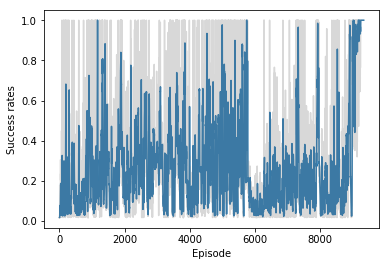

In [210]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Total rewards')

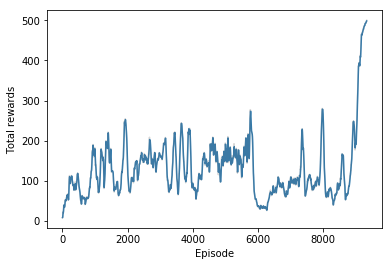

In [211]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Success rates')

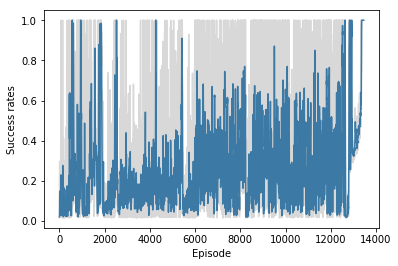

In [185]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Total rewards')

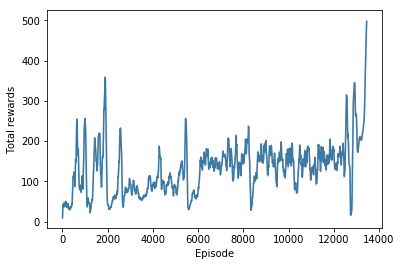

In [186]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Success rates')

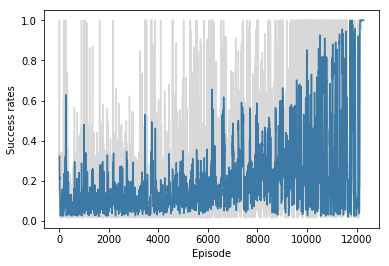

In [166]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Total rewards')

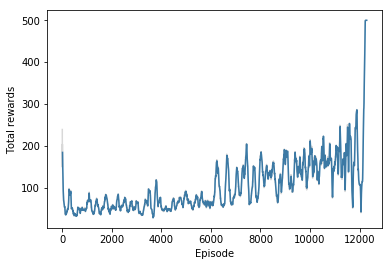

In [161]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

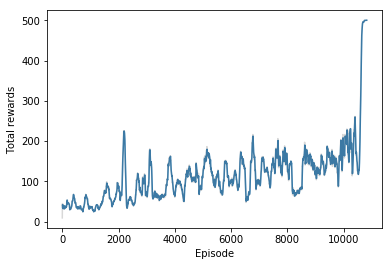

In [146]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

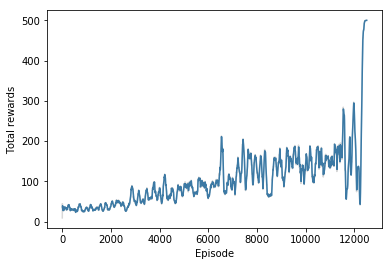

In [131]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

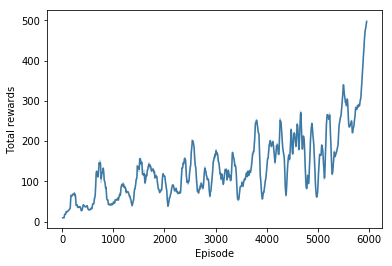

In [116]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

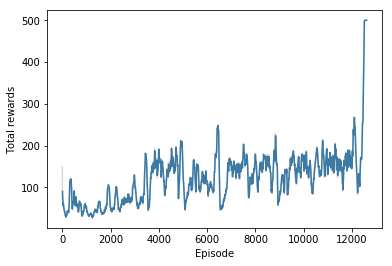

In [98]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

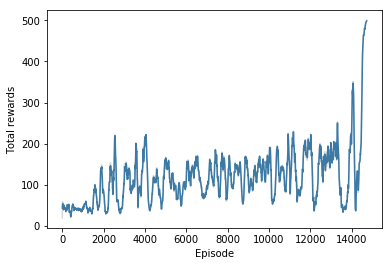

In [70]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

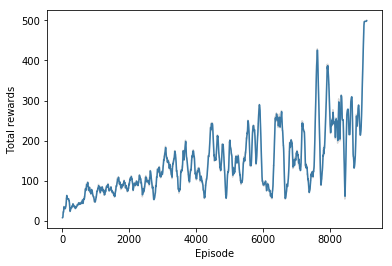

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

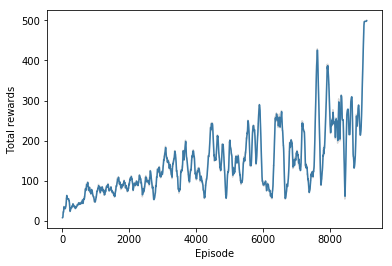

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

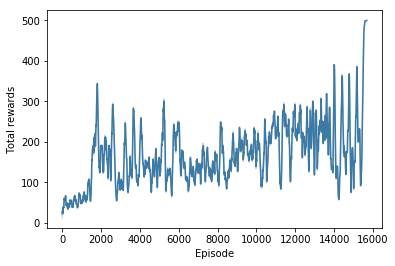

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

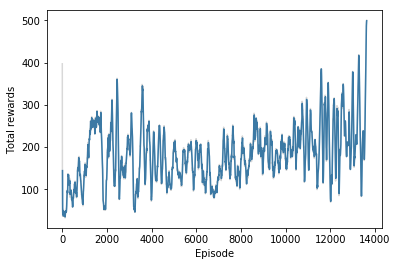

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

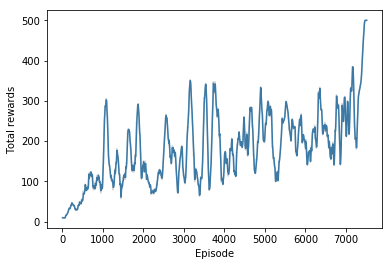

Text(0,0.5,'G losses')

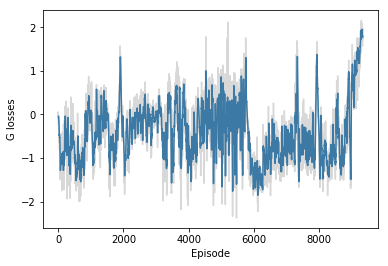

In [212]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

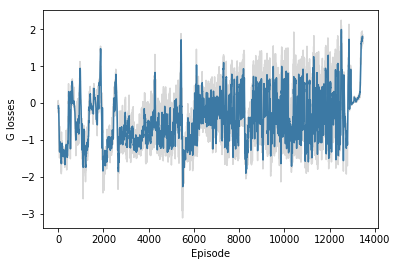

In [187]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

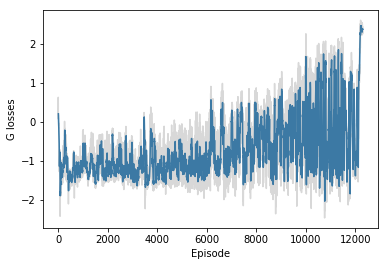

In [162]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

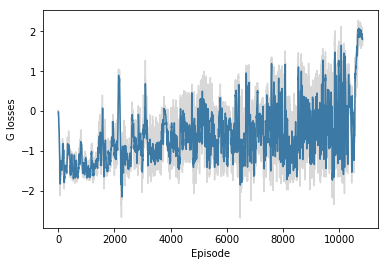

In [147]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

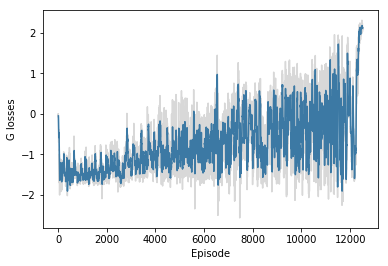

In [132]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

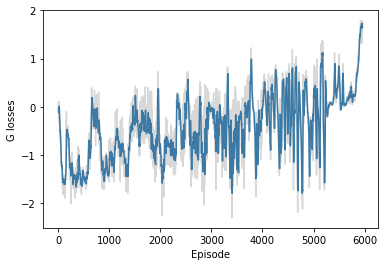

In [117]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

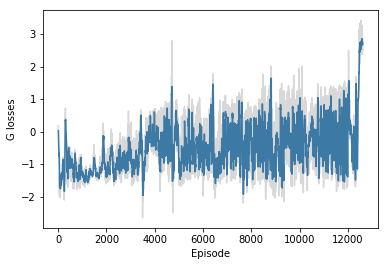

In [99]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

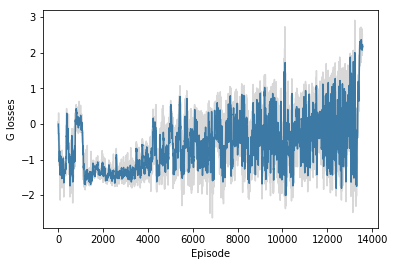

In [83]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

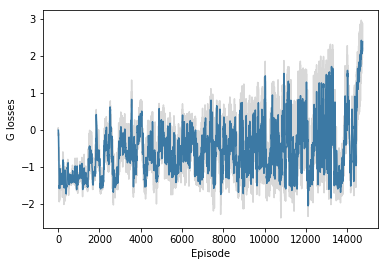

In [71]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

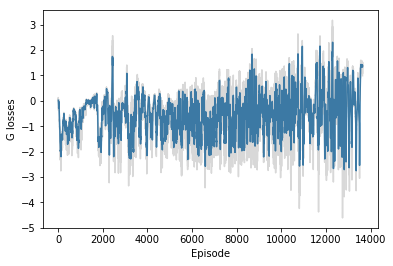

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

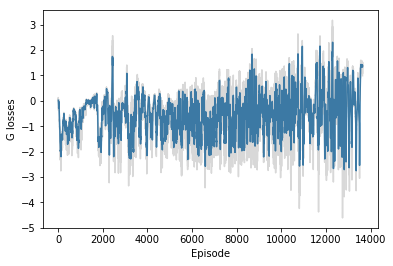

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

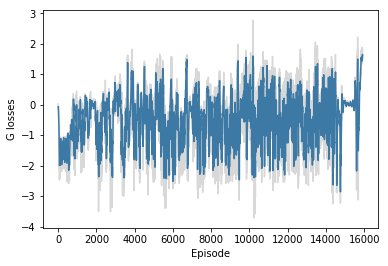
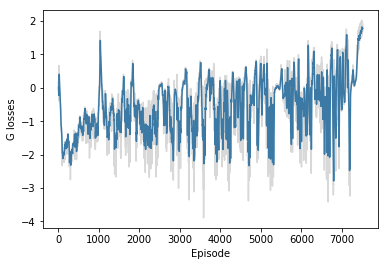

Text(0,0.5,'D losses')

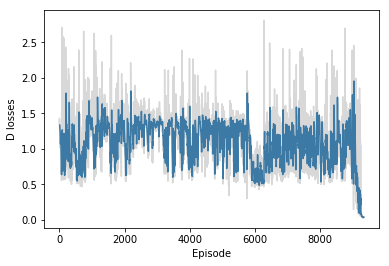

In [213]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

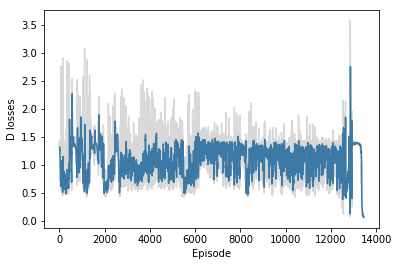

In [188]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

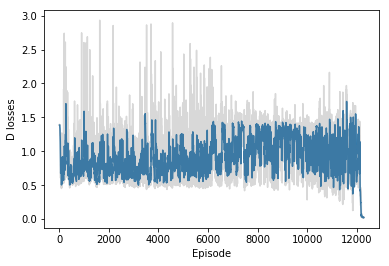

In [163]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

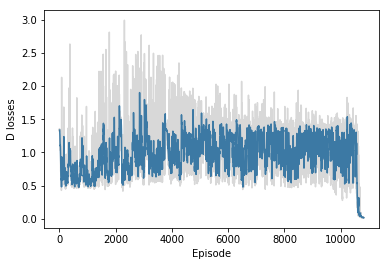

In [148]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

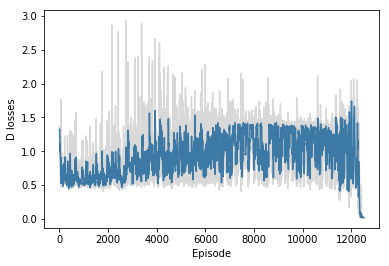

In [133]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

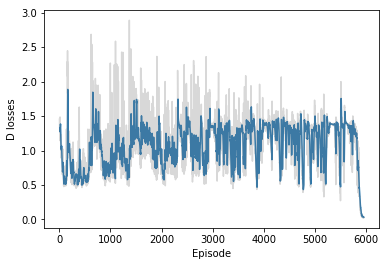

In [118]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

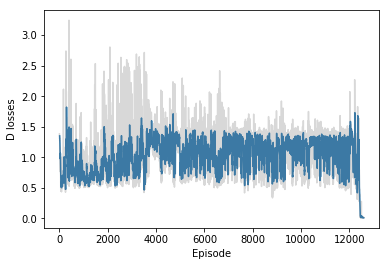

In [100]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

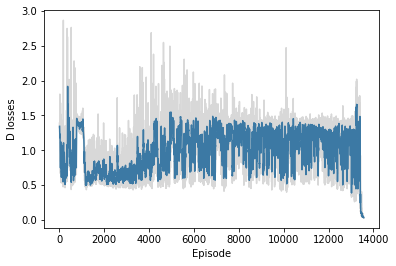

In [84]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

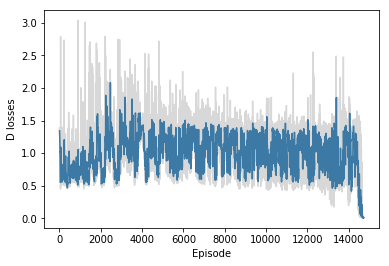

In [72]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

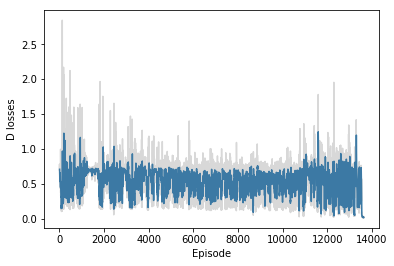

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

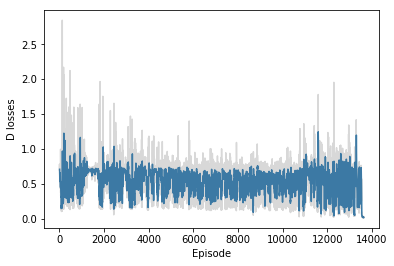

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

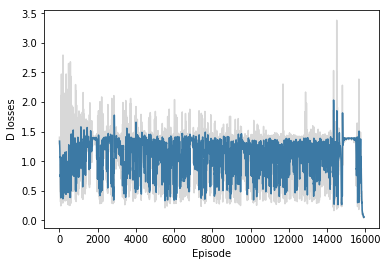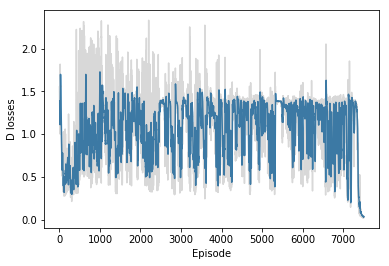

Text(0,0.5,'D losses R')

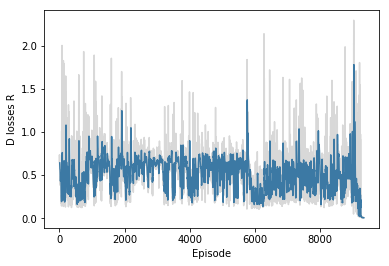

In [214]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

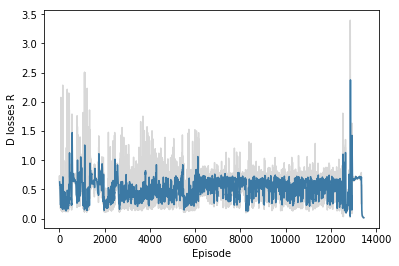

In [189]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

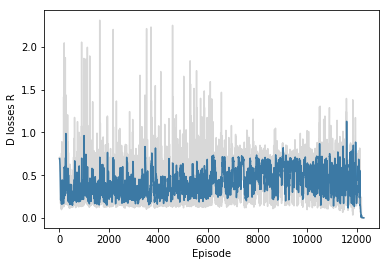

In [164]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

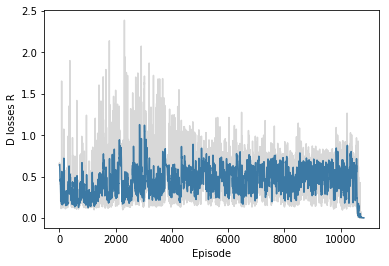

In [149]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

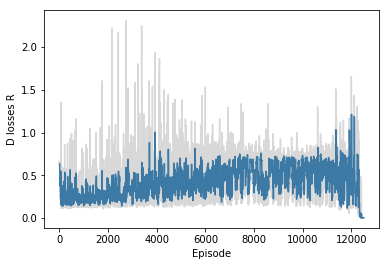

In [134]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

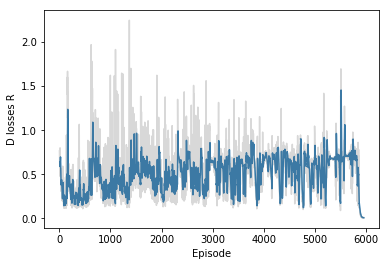

In [119]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

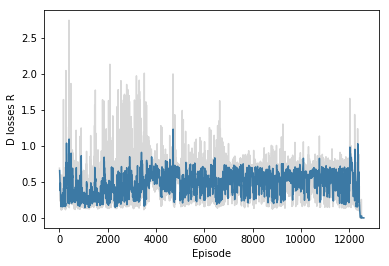

In [101]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

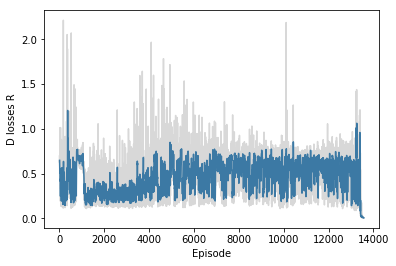

In [85]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

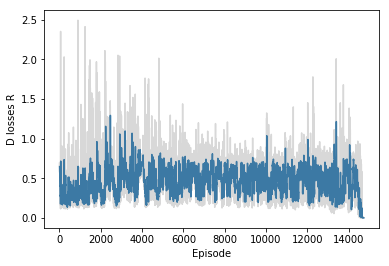

In [73]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

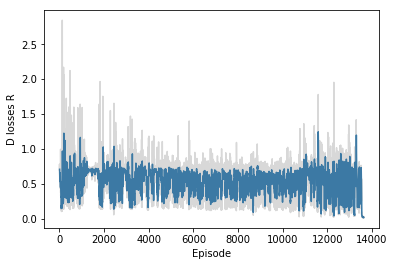

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

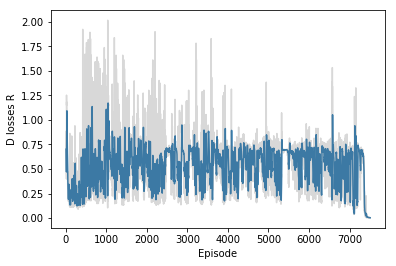

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

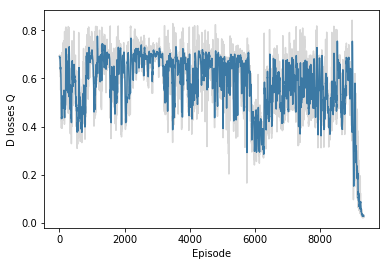

In [215]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

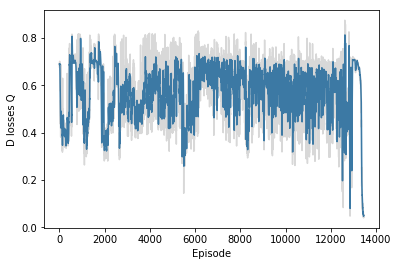

In [190]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

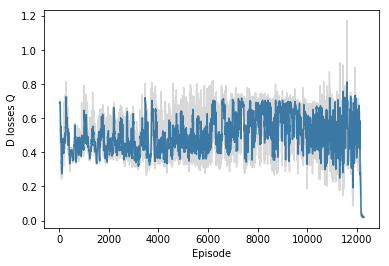

In [165]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

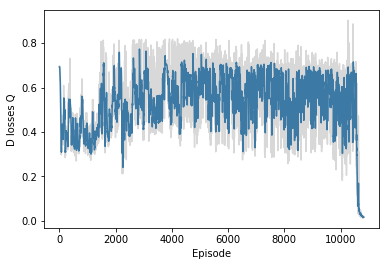

In [150]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

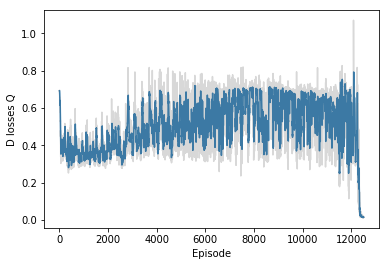

In [135]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

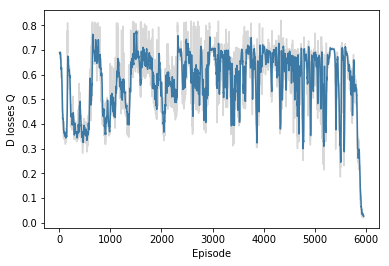

In [120]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

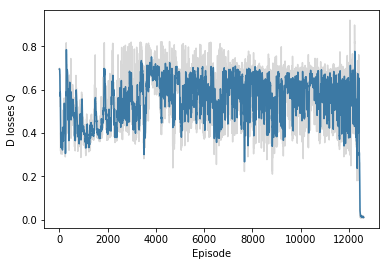

In [102]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

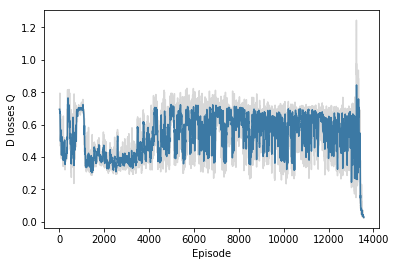

In [86]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

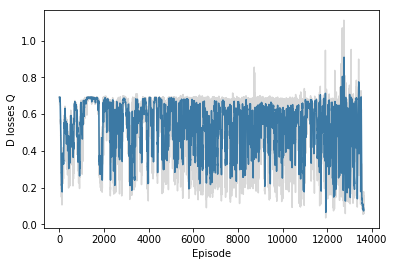

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

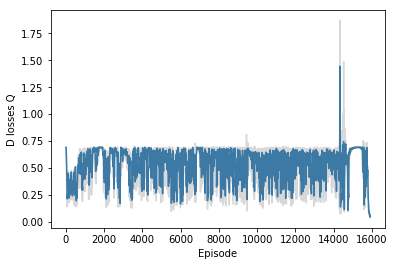

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

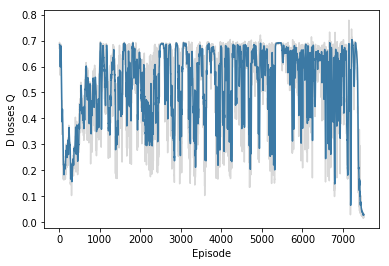

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.